# Analysis of failures to dispute

- I want to see if the users that have failed deposits are users more likely to dispute
- I want to see the ratios
- I want to see the type of failures

DISPUTERS ANALYSIS

In [42]:
import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from IPython.display import display, HTML
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') 

In [3]:
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data

In [4]:
# Current date
current_date = datetime.now()

# Calculate start_time (4 months ago)
start_date = (current_date - relativedelta(months=5)).strftime('%Y-%m-%d')

# Calculate end_time (37 days ago)
end_date = (current_date - timedelta(days=37)).strftime('%Y-%m-%d')

# Print the calculated times
print(f"Start Time: {start_date}")
print(f"End Time: {end_date}")

Start Time: 2024-07-05
End Time: 2024-10-29


In [ ]:
# Query is okay because we want to find users who have disputed/fraud. We don't want to look at the specific rate
final_query = f"""

with base as (
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_59 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date" between '{start_date}' AND '{end_date}' and (("is_true" IS NULL) or ("is_true" = true))
    UNION ALL
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_102 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date"  between '{start_date}' AND '{end_date}' and (("is_true" IS NULL) or ("is_true" = true))
)

, users as (
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_59 
    where "#account_id" is not null
    UNION ALL
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_102
    where "#account_id" is not null
)

, payment_aux AS (
select
    a."#account_id"
    , "register_time"
    , "first_pay_time"
    , b.bundle_id
    , array_agg(cast("net_amount" as double)) as payment_history
    , array_agg("#event_time")                as payment_history_time
    , array_agg("pay_enter_name")             as payment_enter_history
    -- , max(if(date_diff('minute', "first_pay_time", "#event_time") <= 7*24*60, "#event_time", null)) over (partition by "#account_id") as max_date
from base a
join users b
    on a."#account_id" = b."#account_id" 
    and a."#event_time" > b."register_time"
where date_diff('minute', "first_pay_time", "#event_time") between 0 and (7*24*60)
    and "first_pay_time"  between date('{start_date}') AND date('{end_date}') 
group by 1,2,3,4
) 

, ios_payments AS (
  
  select
    a."#account_id"
    , a."first_pay_time"
    , a."bundle_id"
    , payment_history
    , payment_history_time 
    , payment_enter_history 

    , sum((CASE WHEN (date_diff('minute', a."first_pay_time", c."#event_time") <= ((37 * 24) * 60)) THEN 1 ELSE 0 END))                                   disputes_d30  
    , min(c."#event_time")                                                                                                                                first_dispute_time
    
    , date_diff('hour', a."register_time", a."first_pay_time")                                                                                            hours_first_payment 
    , sum(if(date_diff('minute', a.first_pay_time, c."#event_time") <= 7*24*60, 1, 0))                                                                    already_disputed

  FROM payment_aux a
    left join (SELECT *, min("#event_time") over (partition by "#account_id") as first_dispute_time FROM ta.v_event_59 WHERE "$part_event" in ('pay_dispute', 'fraud') AND "$part_date" between '{start_date}' AND '{end_date}')  c 
        -- on a.pay_id = c.pay_id
        on a."#account_id" = c."#account_id"
  group by 1, 2, 3, 4, 5, 6, a."register_time"
) 

,  added_failed_payments as (
    select  
        a. "#account_id"
        , array_agg(1)                              AS payment_fail_history
        , array_agg("#event_time")                  AS payment_fail_history_time
        , array_agg("fail_type")                    AS fail_type_payment_type_history

    from ios_payments a
        left join (select DISTINCT "#account_id", "#event_time", "amount", "net_amount", "fail_type" from ta.v_event_59 where "$part_event" = 'order_pay_fail' AND "$part_date" between '{start_date}' AND '{end_date}') as c 
            on a."#account_id" = c."#account_id" 
            and date_diff('minute', a."first_pay_time", c."#event_time") between 0 and 7*24*60
    
    group by 1 
)

select *
from ios_payments as a
    left join added_failed_payments as b on a."#account_id" = b."#account_id"
"""

print(final_query)



with base as (
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_59 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date" between '2024-07-05' AND '2024-10-29' and (("is_true" IS NULL) or ("is_true" = true))
    UNION ALL
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_102 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date"  between '2024-07-05' AND '2024-10-29' and (("is_true" IS NULL) or ("is_true" = true))
)

, users as (
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_59 
    where "#account_id" is not null
    UNION ALL
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_102
    where "#account_i

In [7]:
df = pull_data(final_query, bs_token, host) 
df.sample(2)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,payment_fail_history,payment_fail_history_time,payment_history,payment_history_time
151087,40866870,40866870,0,com.asselin.android.wildlegends,0,[None],NaN,2024-09-15 03:59:33.586,0,"[default, default]",[1],[None],"[47.5, 47.5]","[2024-09-15 03:59:33.586, 2024-09-15 21:45:07...."
7868,50272731,50272731,0,com.sparklingtour.tig.ger,0,[None],NaN,2024-07-10 08:06:44.892,0,[default],[1],[None],[4.48],[2024-07-10 08:06:44.892]


In [8]:
df['disputes_d30_binary'] = (df['disputes_d30'] > 0).astype(int)
df['disputes_d30_binary'].max()

1

### Check on deposit failure labels 

In [55]:
final_query = f"""

SELECT                              -- Attempted payment amount
    "fail_type",                               -- Failure type from the server
    -- "fail_content",                            -- Failure details or message
    count(*) as cases
    , max("#event_time")
FROM 
    ta.v_event_59
WHERE 
    "$part_event" = 'order_pay_fail'           -- Filters for payment failure events
    AND "$part_date" IS NOT NULL
GROUP BY 1
ORDER BY 2 desc

"""

check_59 = pull_data(final_query, bs_token, host) 
check_59.head(10)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


,_col2,cases,fail_type
0,2024-11-27 10:05:27.624,1158745,
1,2024-11-27 09:48:00.454,1039928,risk
2,2024-11-27 10:05:38.527,781682,funds
3,2024-11-27 10:04:36.141,739053,fraud
4,2024-11-27 10:05:13.390,288810,card
5,2024-11-27 09:57:39.848,226850,decline
6,2024-11-27 10:04:39.343,121849,limit
7,2024-11-27 09:33:45.964,117914,3d
8,2024-11-27 10:03:30.778,113455,invalid
9,2023-12-18 09:39:33.555,91986,NaN


In [ ]:
final_query = f"""
SELECT                              -- Attempted payment amount
    "fail_type",                               -- Failure type from the server
    -- "fail_content",                            -- Failure details or message
    count(*) as cases
    , max("#event_time")
FROM 
    ta.v_event_102
WHERE 
    "$part_event" = 'order_pay_fail'           -- Filters for payment failure events
    AND "$part_date" IS NOT NULL
GROUP BY 1
ORDER BY 2 desc

"""

check_102 = pull_data(final_query, bs_token, host) 
check_102.head(10)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


,_col2,cases,fail_type
0,2024-11-27 10:04:01.164,479412,
1,2024-11-27 10:04:10.548,190495,fraud
2,2024-11-27 10:04:45.474,161045,funds
3,2024-11-27 10:02:13.234,85851,decline
4,2024-11-27 10:04:59.639,55033,card
5,2024-11-27 09:44:04.758,47889,3d
6,2024-11-27 09:54:34.355,25627,invalid
7,2024-11-27 09:54:15.691,23171,risk
8,2024-11-27 10:00:26.782,17040,honor
9,2024-11-27 09:56:37.112,14411,auth


In [117]:
final_query = f"""
SELECT                              -- Attempted payment amount
    "fail_type",                               -- Failure type from the server
    "fail_content",                            -- Failure details or message
    count(*) as cases
FROM 
    ta.v_event_102
WHERE 
    "$part_event" = 'order_pay_fail'           -- Filters for payment failure events
    AND "$part_date" IS NOT NULL
    and "#event_time" > date('2024-10-01')
GROUP BY 1,2
ORDER BY 3 desc

"""

check_102_descriptions = pull_data(final_query, bs_token, host) 
check_102_descriptions.head(10)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


,cases,fail_content,fail_type
0,87021,NaN,
1,35610,"{'details': ['{""issue"":""INSTRUMENT_DECLINED"",""...",
2,19865,"{'response_summary': 'Insufficient Funds', 're...",funds
3,14337,"{'code': '51', 'description': 'Insufficient fu...",funds
4,14190,"{'code': '34', 'description': 'FRAUD SUSPICION'}",fraud
5,14094,"{'pgw_decline_code': 'Suspected_fraud', 'pgw_e...",fraud
6,10682,"{'pgw_decline_code': 'Insufficient_funds', 'pg...",funds
7,10136,"{'code': '540', 'technical_message': 'Not suff...",funds
8,9622,{'response_summary': 'Risk Blocked Transaction...,risk
9,9289,"{'response_summary': 'Suspected Fraud', 'respo...",fraud


In [118]:
 check_102_descriptions.head(1)['fail_type'][0]

''

I want to perform some data validations (Do them after confirming what labels you might consider using)

1. In terms of the data consistency: Are the labels usable across time? 

## Generation of rules based on existence

### Checks

- This needs to be information before making a dispute

In [33]:
print('Select non_disputers on day 7:')
non_disputers_df = df[df['already_disputed'] == 0]

Select non_disputers on day 7:


* You need to use data only before the 7 days or dispute

In [10]:
print('Sample disputer details:')
non_disputers_df[~non_disputers_df['first_dispute_time'].isnull()][['first_pay_time', 'payment_fail_history_time', 'fail_type_payment_type_history', 'payment_fail_history', 'first_dispute_time']].sample(1).values[0]

Sample disputer details:


array(['2024-10-05 14:06:30.313',
       list(['2024-10-05 18:31:35.257', '2024-10-10 14:24:45.359', '2024-10-07 11:50:32.275', '2024-10-05 18:31:35.937', '2024-10-07 11:50:31.926', '2024-10-05 21:51:00.995', '2024-10-05 21:50:59.633', '2024-10-11 13:49:17.781', '2024-10-06 05:32:58.453', '2024-10-08 01:08:39.160', '2024-10-06 15:02:08.994', '2024-10-10 16:36:18.201', '2024-10-06 15:02:09.539', '2024-10-10 14:24:46.340', '2024-10-10 16:36:16.531', '2024-10-05 21:50:28.039', '2024-10-10 17:00:15.038', '2024-10-10 16:36:00.497', '2024-10-10 16:36:02.245', '2024-10-11 13:49:20.658', '2024-10-11 10:03:40.846', '2024-10-12 04:40:36.796', '2024-10-08 19:48:23.034', '2024-10-05 21:50:28.834', '2024-10-10 17:00:16.471', '2024-10-08 01:08:39.539', '2024-10-11 10:03:40.381', '2024-10-12 04:40:36.877', '2024-10-08 19:48:24.199', '2024-10-06 05:33:00.252']),
       list(['', '', 'fraud', '', '', 'fraud', '', 'fraud', 'fraud', 'fraud', '', '', '', 'fraud', '', 'fraud', 'fraud', '', 'fraud', 'fraud'

In [23]:
print('Sum, average, and cumulative sum for each bundle_id:')

# Calculate sum, average, and cumulative sum for each bundle_id
result = non_disputers_df.groupby('bundle_id').agg(
    sum_disputes = ('disputes_d30_binary', 'sum'),
    avg_disputes = ('disputes_d30_binary', 'mean')
).reset_index().sort_values(by = 'sum_disputes', ascending = False)

# Add cumulative sum of disputes
result['cumulated_sum_disputes'] = result['sum_disputes'].cumsum()
result.head()

Sum, average, and cumulative sum for each bundle_id:


,bundle_id,sum_disputes,avg_disputes,cumulated_sum_disputes
32,com.reelsflight.newb,207,0.008462,207
37,com.sparklspin.reluck,172,0.007426,379
8,com.asselin.luckylegends,160,0.008453,539
39,com.whiskers.goldslots,116,0.008019,655
1,com.acorncasino.slots,96,0.006688,751


### Volume research (Necessary to run)

Check how many times a user makes a dispute and the associated dispute rate. 

In [43]:
print('Create the count of failures:')
non_disputers_df['num_failures'] = (non_disputers_df['payment_fail_history'].apply(lambda x: len(x))).astype(float)

Create the count of failures:


In [44]:
print('Display of dispute rate by case:')
dispute_freq_grouped = non_disputers_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop = False)
dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

Display of dispute rate by case:


,num_failures,disputes_d30_binary
0,1.0,0.002124
1,2.0,0.003034
2,3.0,0.010253
3,4.0,0.009957
4,5.0,0.014783
5,6.0,0.011281
6,7.0,0.016418
7,8.0,0.014225
8,9.0,0.014469
9,10.0,0.021875


Below we start preparing the plot

In [45]:
print('Create dispute_freq_grouped and filter to less than 50 for display')
dispute_freq_grouped = non_disputers_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop = False)
dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]

Create dispute_freq_grouped and filter to less than 50 for display


In [46]:
# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

# Filter for visualization limit
# dispute_freq_grouped['num_failures']['num_failures'] = dispute_freq_grouped['num_failures']
dispute_freq_grouped.head(40)

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,1.0,0.002124,521,0.019599,99.980401
1,2.0,0.003034,147,0.047598,99.952402
2,3.0,0.010253,34,0.142220,99.857780
3,4.0,0.009957,83,0.234105,99.765895
4,5.0,0.014783,17,0.370524,99.629476
5,6.0,0.011281,45,0.474630,99.525370
6,7.0,0.016418,11,0.626141,99.373859
7,8.0,0.014225,37,0.757417,99.242583
8,9.0,0.014469,9,0.890947,99.109053
9,10.0,0.021875,35,1.092817,98.907183


In [47]:
dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,1.0,0.002124,521,0.019599,5.111387
1,2.0,0.003034,147,0.047598,5.134605
2,3.0,0.010253,34,0.142220,5.157611
3,4.0,0.009957,83,0.234105,5.177382
4,5.0,0.014783,17,0.370524,5.197487
5,6.0,0.011281,45,0.474630,5.215454
6,7.0,0.016418,11,0.626141,5.235295
7,8.0,0.014225,37,0.757417,5.252825
8,9.0,0.014469,9,0.890947,5.271601
9,10.0,0.021875,35,1.092817,5.290441


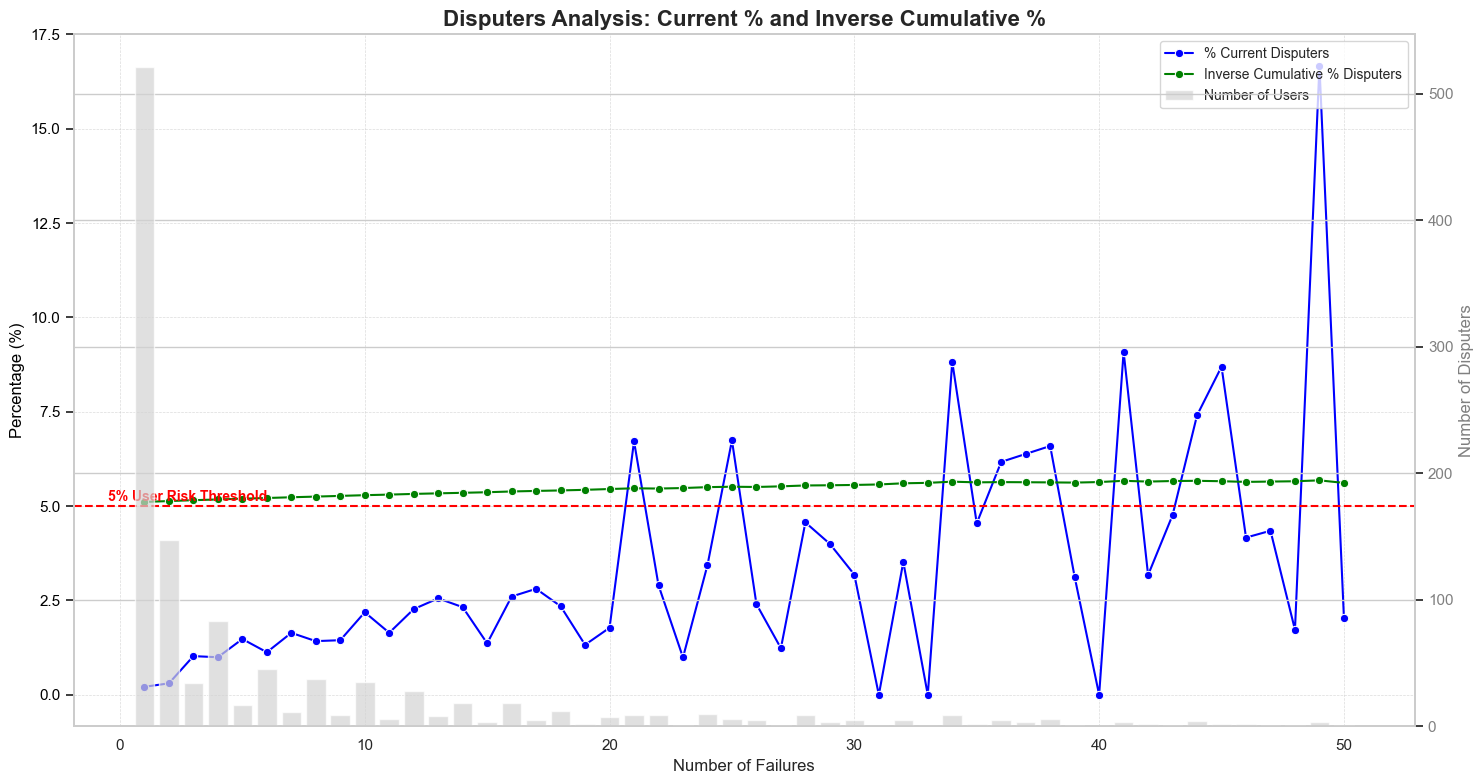

In [48]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Users', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### Extend the analysis to different deposit types

In [ ]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('decline')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

# Filter for visualization limit
# dispute_freq_grouped['num_failures']['num_failures'] = dispute_freq_grouped['num_failures']
dispute_freq_grouped.head(40)

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,1.0,0.002222,1,0.028923,99.971077
1,2.0,0.001634,1,0.050190,99.949810
2,3.0,0.015810,4,0.255968,99.744032
3,4.0,0.009107,5,0.374505,99.625495
4,5.0,0.005814,1,0.450176,99.549824
5,6.0,0.013850,5,0.630445,99.369555
6,7.0,0.009259,1,0.750959,99.249041
7,8.0,0.003135,1,0.791759,99.208241
8,9.0,0.000000,0,0.791759,99.208241
9,10.0,0.014851,3,0.985058,99.014942


In [97]:
dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,1.0,0.002222,1,0.028923,5.122127
1,2.0,0.001634,1,0.050190,5.155012
2,3.0,0.015810,4,0.255968,5.188739
3,4.0,0.009107,5,0.374505,5.213281
4,5.0,0.005814,1,0.450176,5.242751
5,6.0,0.013850,5,0.630445,5.274898
6,7.0,0.009259,1,0.750959,5.301911
7,8.0,0.003135,1,0.791759,5.332512
8,9.0,0.000000,0,0.791759,5.367858
9,10.0,0.014851,3,0.985058,5.405928


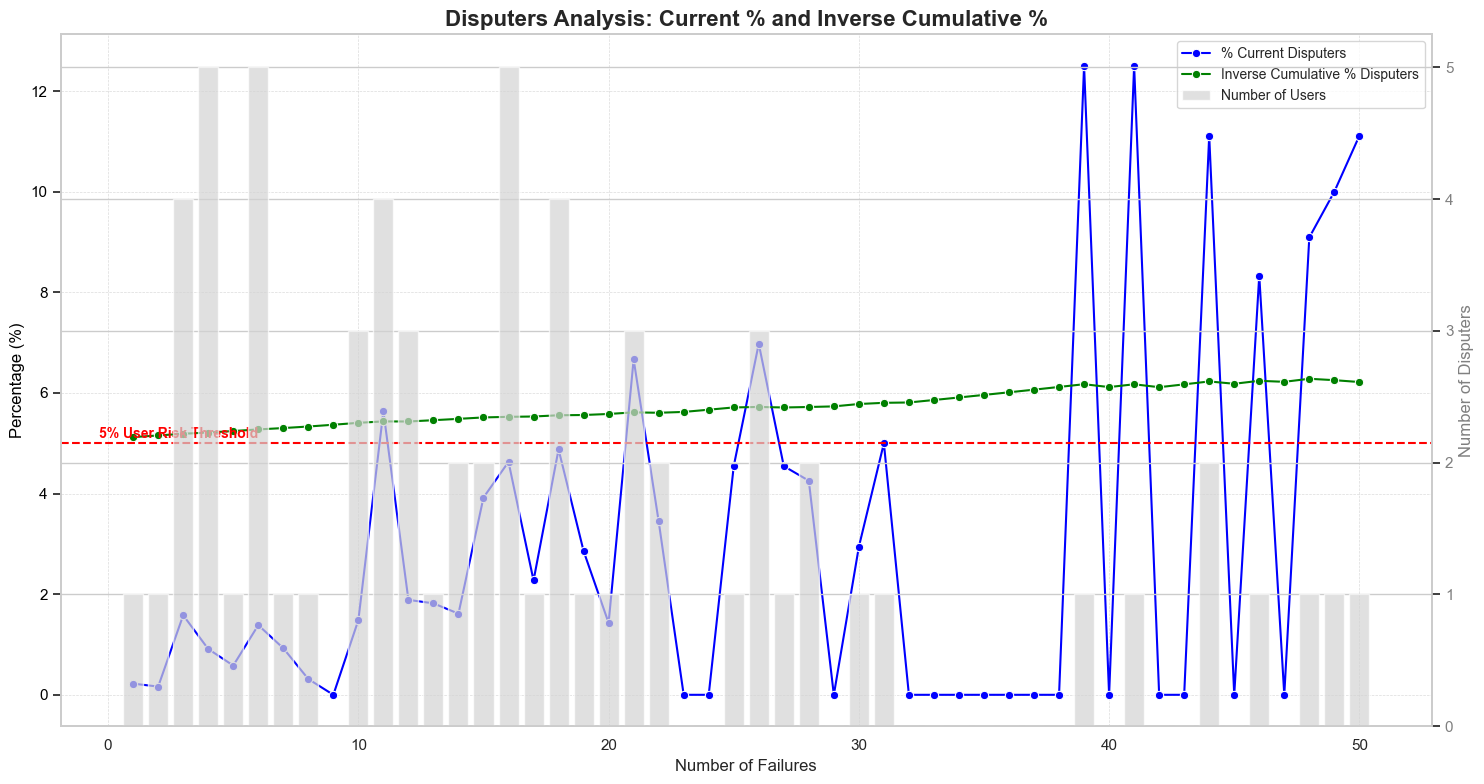

In [98]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Users', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


- Any decline deposit failure can be considered an issue 

In [102]:
non_disputers_decline_df.shape

(1695, 17)

### Funds

In [104]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('funds')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,2.0,0.000000,0,0.000000,5.836972
1,3.0,0.041667,2,0.502705,5.878369
2,4.0,0.000000,0,0.502705,5.890595
3,5.0,0.000000,0,0.502705,5.932974
4,6.0,0.017544,2,0.714370,5.975966
5,7.0,0.000000,0,0.714370,6.006781
6,8.0,0.008696,1,0.819282,6.050948
7,9.0,0.000000,0,0.819282,6.089329
8,10.0,0.022989,2,1.096636,6.134772
9,11.0,0.066667,2,1.900963,6.163613


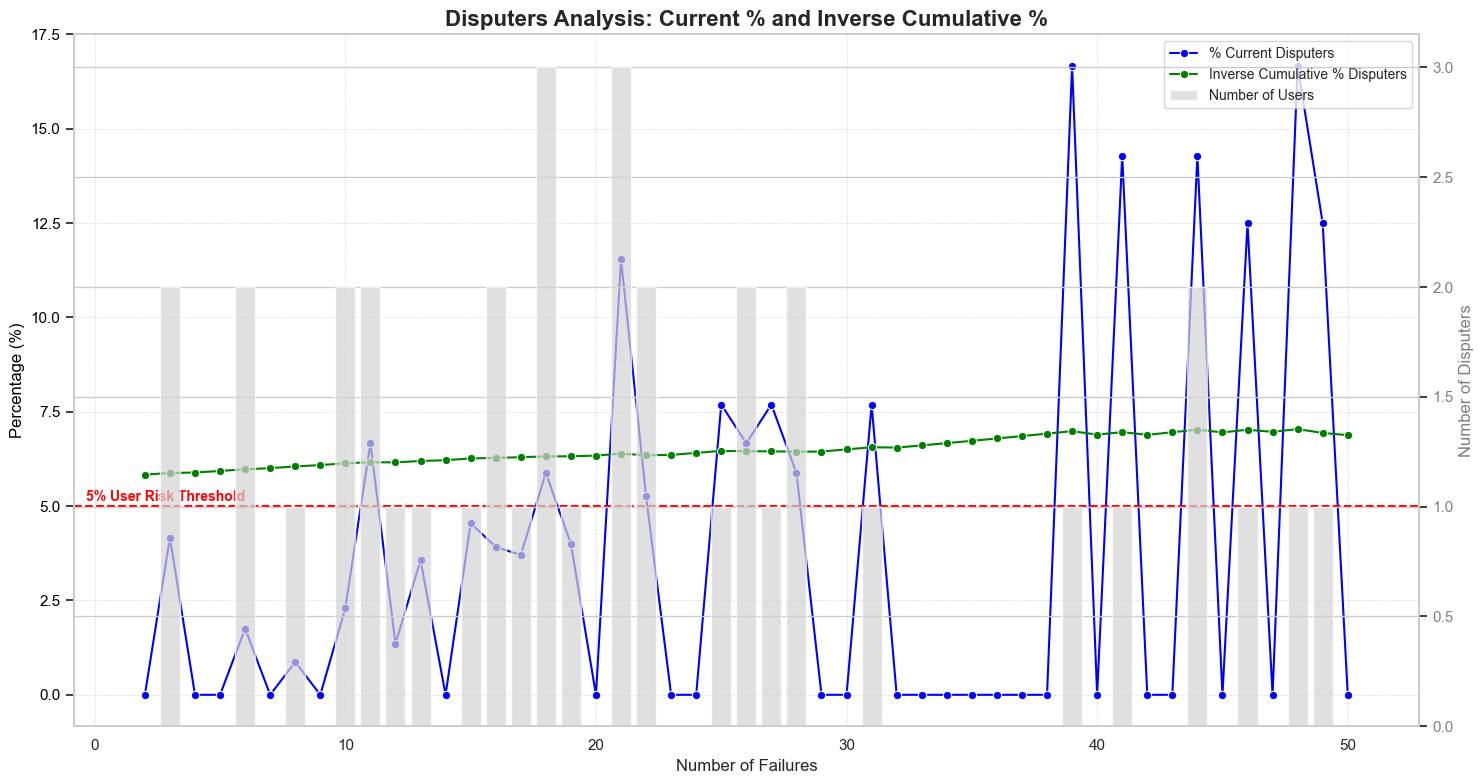

In [ ]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Users', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

### Card

In [112]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('card')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,2.0,0.000000,0,0.000000,4.857377
1,3.0,0.000000,0,0.000000,4.896868
2,4.0,0.000000,0,0.000000,4.937006
3,5.0,0.000000,0,0.000000,4.977808
4,6.0,0.000000,0,0.000000,5.019290
5,7.0,0.066667,1,1.106841,5.061469
6,8.0,0.016129,1,1.374625,5.047865
7,9.0,0.000000,0,1.374625,5.077224
8,10.0,0.037037,2,1.989537,5.120993
9,11.0,0.105263,2,3.737180,5.133317


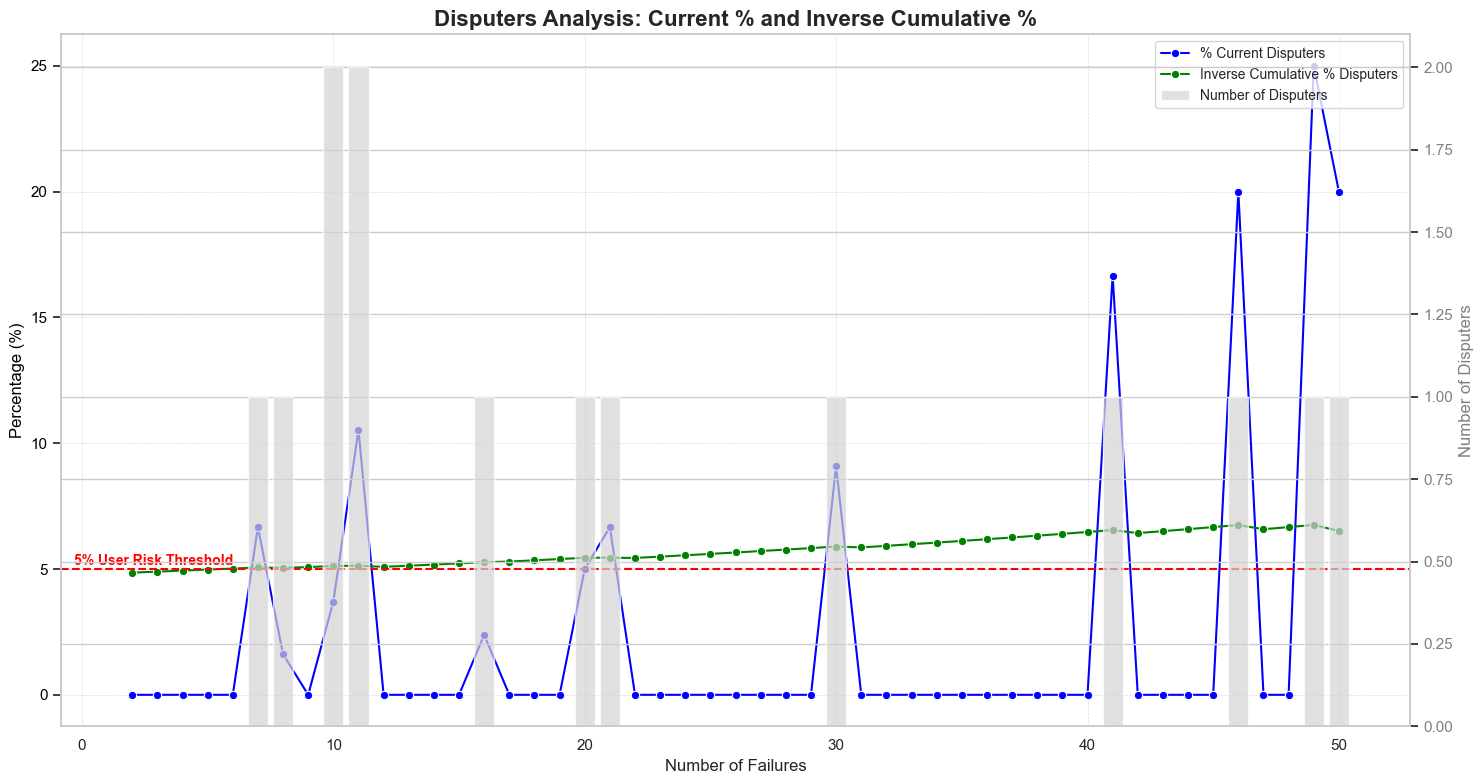

In [113]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### Account

In [164]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('account')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 60]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,3.0,0.000000,0,0.000000,9.186882
1,4.0,0.000000,0,0.000000,9.363553
2,6.0,0.000000,0,0.000000,9.547152
3,7.0,0.000000,0,0.000000,9.738095
4,8.0,0.000000,0,0.000000,9.936832
5,9.0,0.000000,0,0.000000,10.143849
6,10.0,0.250000,1,5.134474,10.359676
7,11.0,0.000000,0,5.134474,10.041408
8,12.0,0.142857,1,8.068460,10.264550
9,13.0,0.000000,0,8.068460,10.173160


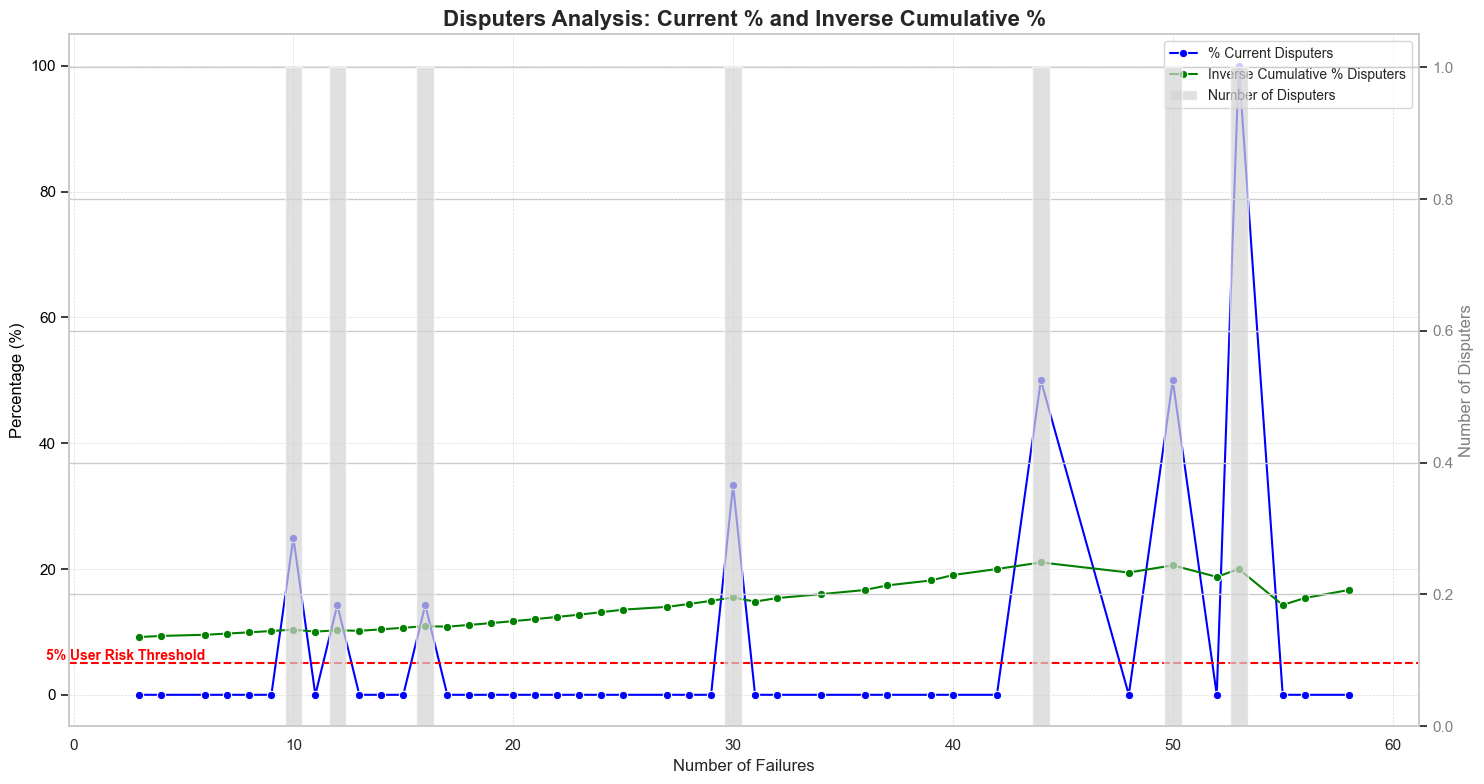

In [165]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### black

In [159]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('black')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,4.0,1.0,1,25.0,12.121212
1,6.0,0.0,0,25.0,9.375000
2,8.0,0.0,0,25.0,9.677419
3,10.0,0.0,0,25.0,10.000000
4,11.0,0.0,0,25.0,10.344828
5,12.0,0.0,0,25.0,10.714286
6,14.0,0.0,0,25.0,11.111111
7,16.0,0.0,0,25.0,11.538462
8,18.0,0.0,0,25.0,12.000000
9,19.0,0.0,0,25.0,12.500000


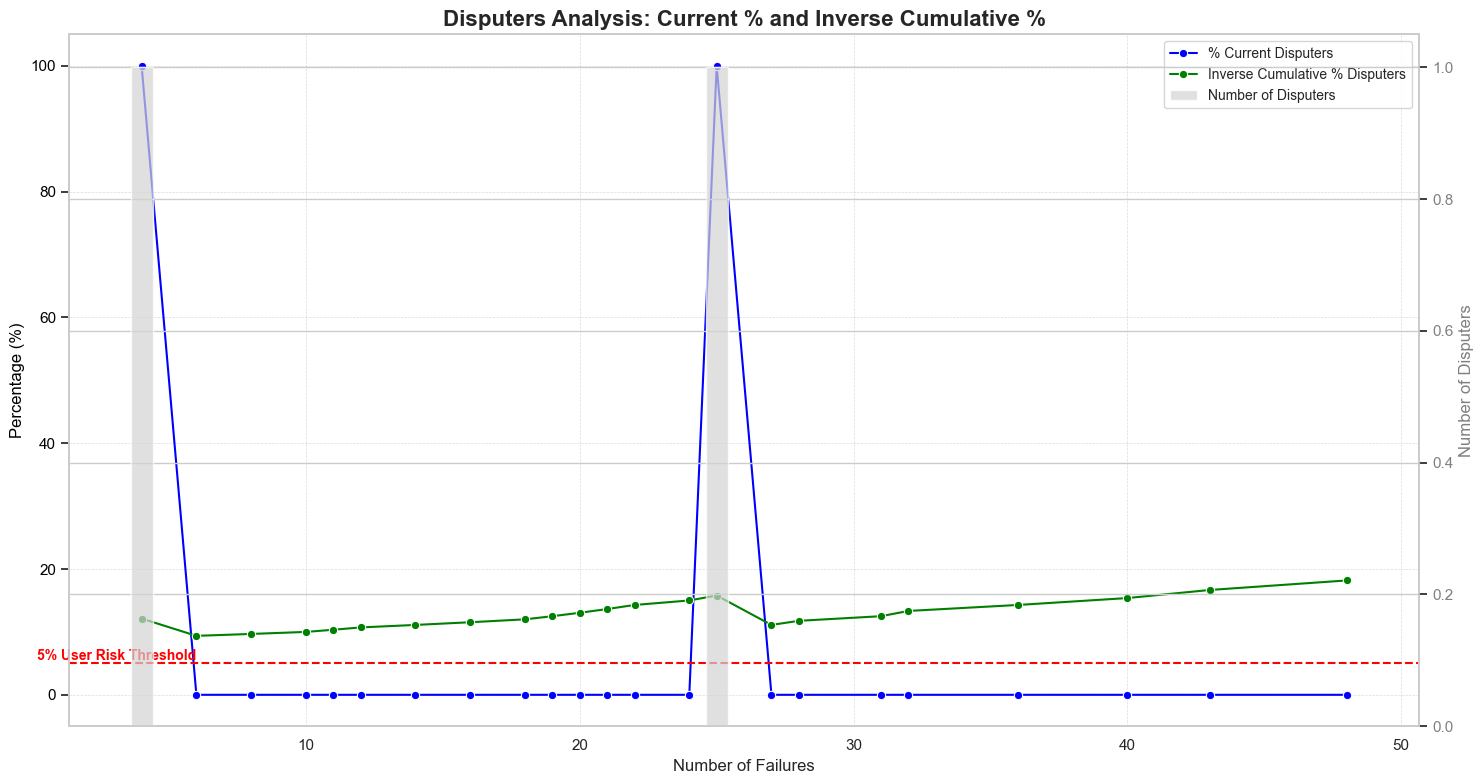

In [160]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


In [163]:
# Can you tell me why black has this issues 

df[df['fail_type_payment_type_history'].astype(str).str.contains('black')][df['disputes_d30_binary'] > 0]

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,payment_fail_history,payment_fail_history_time,payment_history,payment_history_time,disputes_d30_binary
8618,50394408,50394408,0,com.sparklspin.reluck,2,"[black, black, fraud, black, fraud, fraud, fra...",2024-09-07 09:30:02.803,2024-08-23 23:05:58.670,0,"[default, default, start_pack]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2024-08-24 00:07:36.616, 2024-08-24 00:55:35....","[96.023, 47.918, 47.918]","[2024-08-23 23:18:41.795, 2024-08-23 23:05:58....",1
12076,50293986,50293986,9,com.sparklspin.reluck,9,"[, black, black, invalid, invalid, , invalid, ...",2024-07-24 13:00:04.082,2024-07-24 00:54:10.829,28,"[sub_pack, money_return, start_pack, first_b, ...","[1, 1, 1, 1, 1, 1, 1, 1]","[2024-07-24 02:02:38.665, 2024-07-24 03:38:49....","[6.39, 3.52, 4.48, 2.57, 11.17, 9.26, 22.64, 9...","[2024-07-24 03:37:20.157, 2024-07-24 01:15:25....",1
25581,50068464,50068464,0,com.whiskers.goldslots,2,"[decline, black, black, decline]",2024-07-24 15:19:35.286,2024-06-28 10:26:20.431,1665,"[default, default, default, default, default, ...","[1, 1, 1, 1]","[2024-06-29 02:54:57.742, 2024-06-29 02:57:35....","[47.5, 18.82, 18.82, 18.82, 18.82, 18.82, 18.82]","[2024-06-29 03:00:09.929, 2024-07-02 22:38:58....",1
66825,50188174,50188174,0,com.whiskers.goldslots,4,"[black, funds, funds, black]",2024-07-22 09:30:04.285,2024-06-29 15:22:52.750,635,"[default, default, default]","[1, 1, 1, 1]","[2024-06-30 18:42:50.982, 2024-06-30 09:50:37....","[9.434, 9.12, 46.6]","[2024-06-29 15:22:52.750, 2024-06-30 08:29:28....",1
67988,50369469,50369469,0,com.sparklspin.reluck,1,"[fraud, fraud, fraud, black, black, black, fun...",2024-08-26 09:30:02.842,2024-08-18 16:56:52.210,0,"[default, default, start_pack, default, money_...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2024-08-20 01:41:42.163, 2024-08-20 01:34:19....","[47.918, 96.023, 71.9705, 9.434, 52.7285, 4.6235]","[2024-08-22 02:35:30.748, 2024-08-20 01:32:16....",1
71555,50159345,50159345,0,com.whiskers.goldslots,37,"[limit, limit, limit, limit, auth, limit, auth...",2024-07-13 18:25:03.360,2024-06-28 22:04:31.671,834,"[default, default, start_pack, default, defaul...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2024-06-29 06:57:58.059, 2024-06-29 08:31:34....","[4.6235, 9.434, 19.055, 4.6235, 9.434, 4.6235,...","[2024-07-03 00:02:23.954, 2024-07-03 23:17:48....",1
78042,50146105,50146105,0,com.whiskers.goldslots,25,"[fraud, funds, fraud, black, fraud, fraud, fra...",2024-07-18 21:36:09.928,2024-07-04 03:36:53.618,1082,"[default, default, default, default, default, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2024-07-08 08:04:54.870, 2024-07-10 18:03:24....","[4.6235, 4.6235, 4.6235, 4.6235, 4.6235, 9.434...","[2024-07-09 13:55:27.152, 2024-07-04 04:03:43....",1
87663,50256718,50256718,6,com.whiskers.goldslots,6,"[black, black]",2024-07-12 12:27:04.531,2024-07-06 01:35:10.221,287,"[default, lucky_flip, first_b, default, first_...","[1, 1]","[2024-07-06 10:55:35.322, 2024-07-06 10:55:33....","[18.82, 9.26, 11.17, 9.26, 2.57, 4.48]","[2024-07-06 10:49:54.579, 2024-07-06 01:45:11....",1
91493,50304684,50304684,0,com.sparklspin.reluck,1,"[3d, 3d, black, 3d, auth, funds, black, 3d, fu...",2024-08-03 09:30:03.513,2024-07-26 11:13:38.744,0,"[first_b, default, first_b]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2024-08-02 09:19:39.017, 2024-08-02 09:19:36....","[2.6993, 19.055, 11.3582]","[2024-07-26 11:13:38.744, 2024-07-27 04:32:18....",1
109367,50306043,50306043,1,com.sparklspin.reluck,71,"[inner_risk_control, black, funds, inner_risk_...",2024-08-01 08:07:51.646,2024-07-27 00:44:15.383,0,"[default, default, default, default, default, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2024-07-29 09:33:32.334, 2024-07-31 05:51:10....","[19.055, 19.055, 18.82, 19.055, 19.055, 47.918..

### Fraud

In [110]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('fraud')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,2.0,0.000000,0,0.000000,6.547880
1,3.0,0.000000,0,0.000000,6.594650
2,4.0,0.015873,1,0.171925,6.642094
3,5.0,0.000000,0,0.171925,6.678723
4,6.0,0.000000,0,0.171925,6.727473
5,7.0,0.000000,0,0.171925,6.776939
6,8.0,0.000000,0,0.171925,6.827139
7,9.0,0.000000,0,0.171925,6.878088
8,10.0,0.000000,0,0.171925,6.929803
9,11.0,0.074074,2,0.974243,6.982301


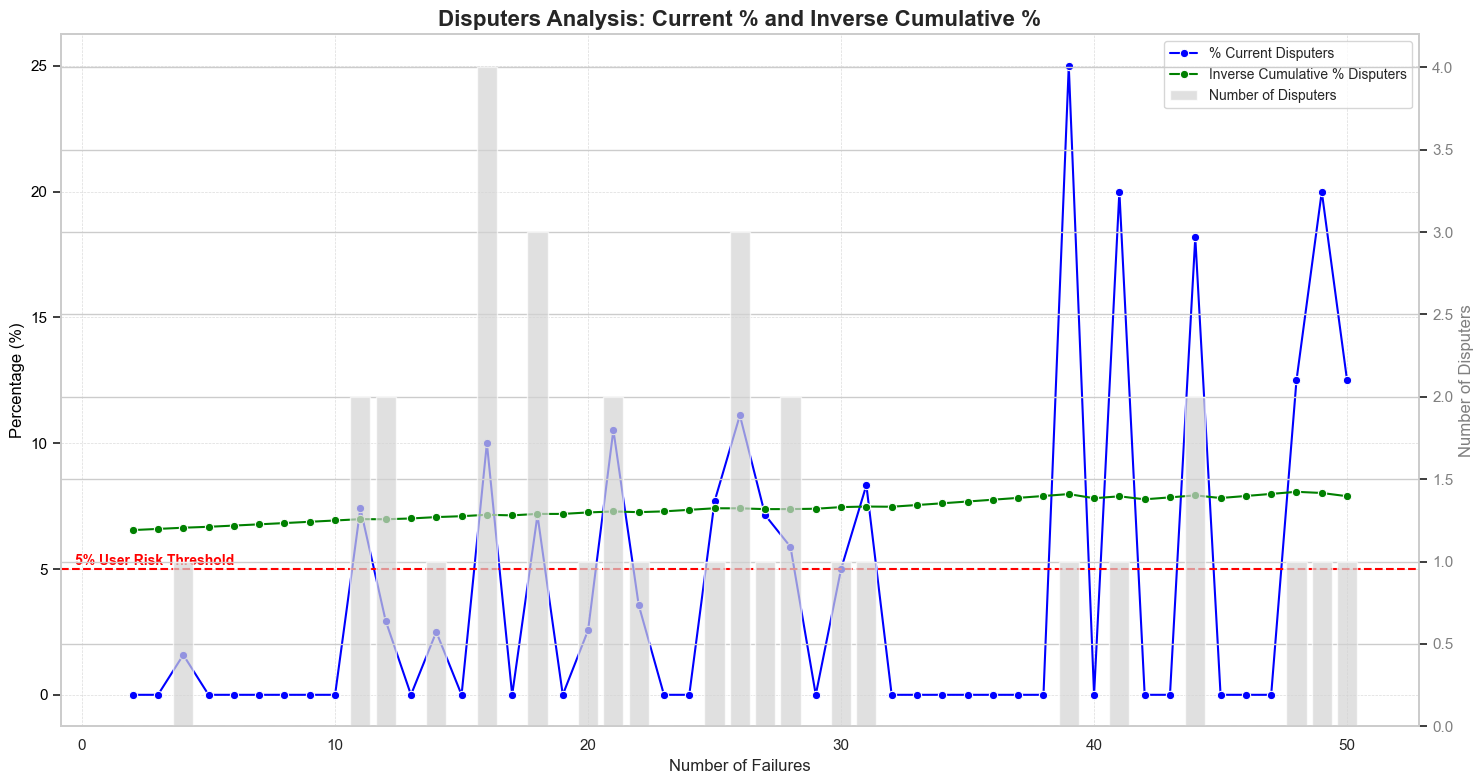

In [111]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### 3d

In [114]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('3d')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,2.0,0.100000,1,1.359776,6.937882
1,3.0,0.000000,0,1.359776,6.908719
2,4.0,0.058824,1,2.159643,6.975149
3,5.0,0.000000,0,2.159643,6.985759
4,6.0,0.000000,0,2.159643,7.054247
5,7.0,0.000000,0,2.159643,7.124091
6,8.0,0.000000,0,2.159643,7.195331
7,9.0,0.000000,0,2.159643,7.268012
8,10.0,0.000000,0,2.159643,7.342175
9,11.0,0.111111,1,3.670505,7.417867


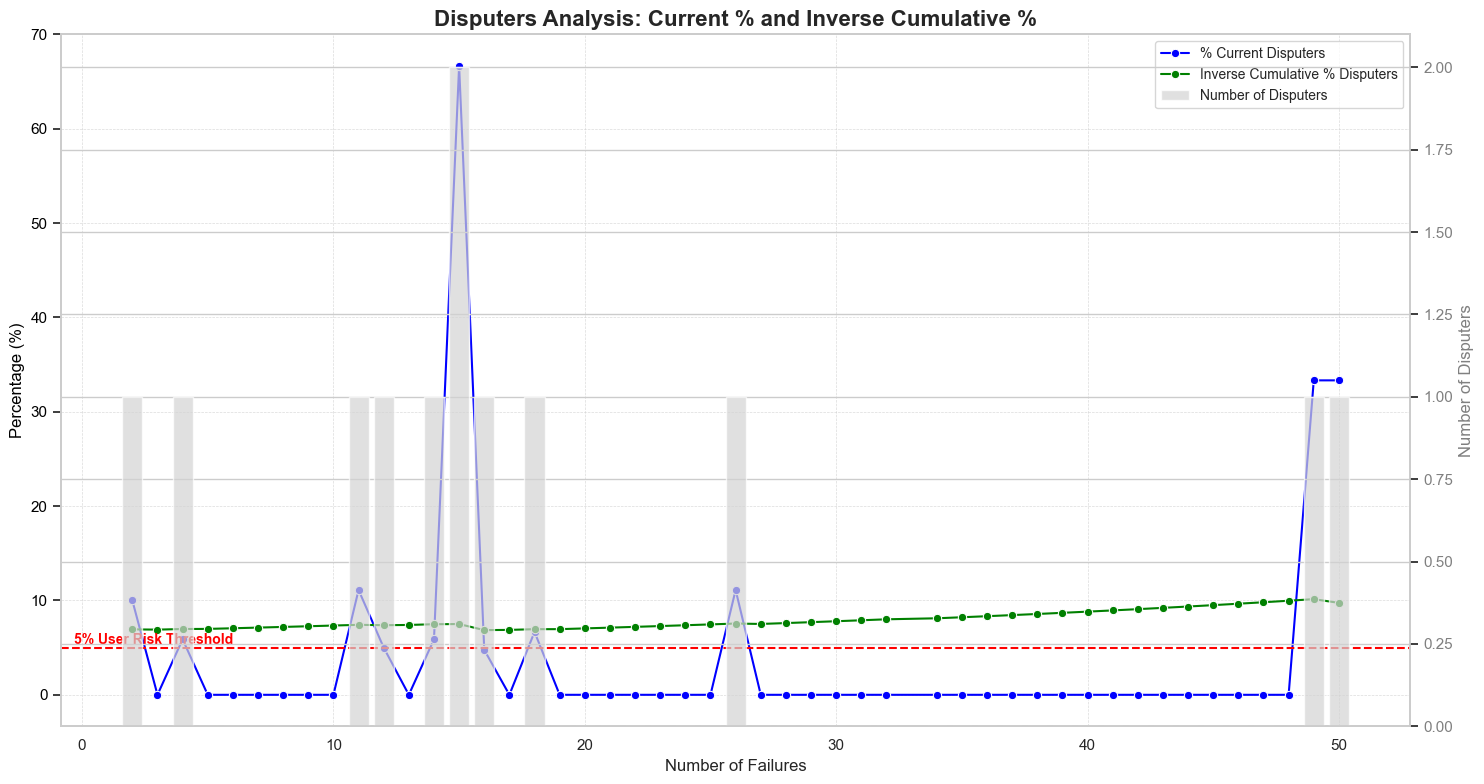

In [115]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### Empty type

I want a python piece of code that 

That via looping checks if any case in fail_type_payment_type_history contains one of the items in the list unique()

In [119]:
### You want to do the check on others as well 
non_disputers_decline_df = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].astype(str).str.contains('')]

# Grouping and calculating statistics
dispute_freq_grouped = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].mean().reset_index(drop=False)
dispute_freq_grouped['num_users'] = non_disputers_decline_df.groupby('num_failures')['disputes_d30_binary'].sum().values

dispute_freq_grouped['cumulative_dispute_percentage'] = 100 * dispute_freq_grouped['disputes_d30_binary'].cumsum() / dispute_freq_grouped['disputes_d30_binary'].sum()
dispute_freq_grouped['inverse_cumulative_percentage'] = 100 - dispute_freq_grouped['cumulative_dispute_percentage']

dispute_freq_grouped['inverse_cumulative_percentage'] = [
    dispute_freq_grouped.loc[i:, 'disputes_d30_binary'].mean() * 100
    for i in range(len(dispute_freq_grouped))
]

dispute_freq_grouped = dispute_freq_grouped[dispute_freq_grouped['num_failures'] <= 50]
dispute_freq_grouped

,num_failures,disputes_d30_binary,num_users,cumulative_dispute_percentage,inverse_cumulative_percentage
0,1.0,0.002222,1,0.028923,5.122127
1,2.0,0.001634,1,0.050190,5.155012
2,3.0,0.015810,4,0.255968,5.188739
3,4.0,0.009107,5,0.374505,5.213281
4,5.0,0.005814,1,0.450176,5.242751
5,6.0,0.013850,5,0.630445,5.274898
6,7.0,0.009259,1,0.750959,5.301911
7,8.0,0.003135,1,0.791759,5.332512
8,9.0,0.000000,0,0.791759,5.367858
9,10.0,0.014851,3,0.985058,5.405928


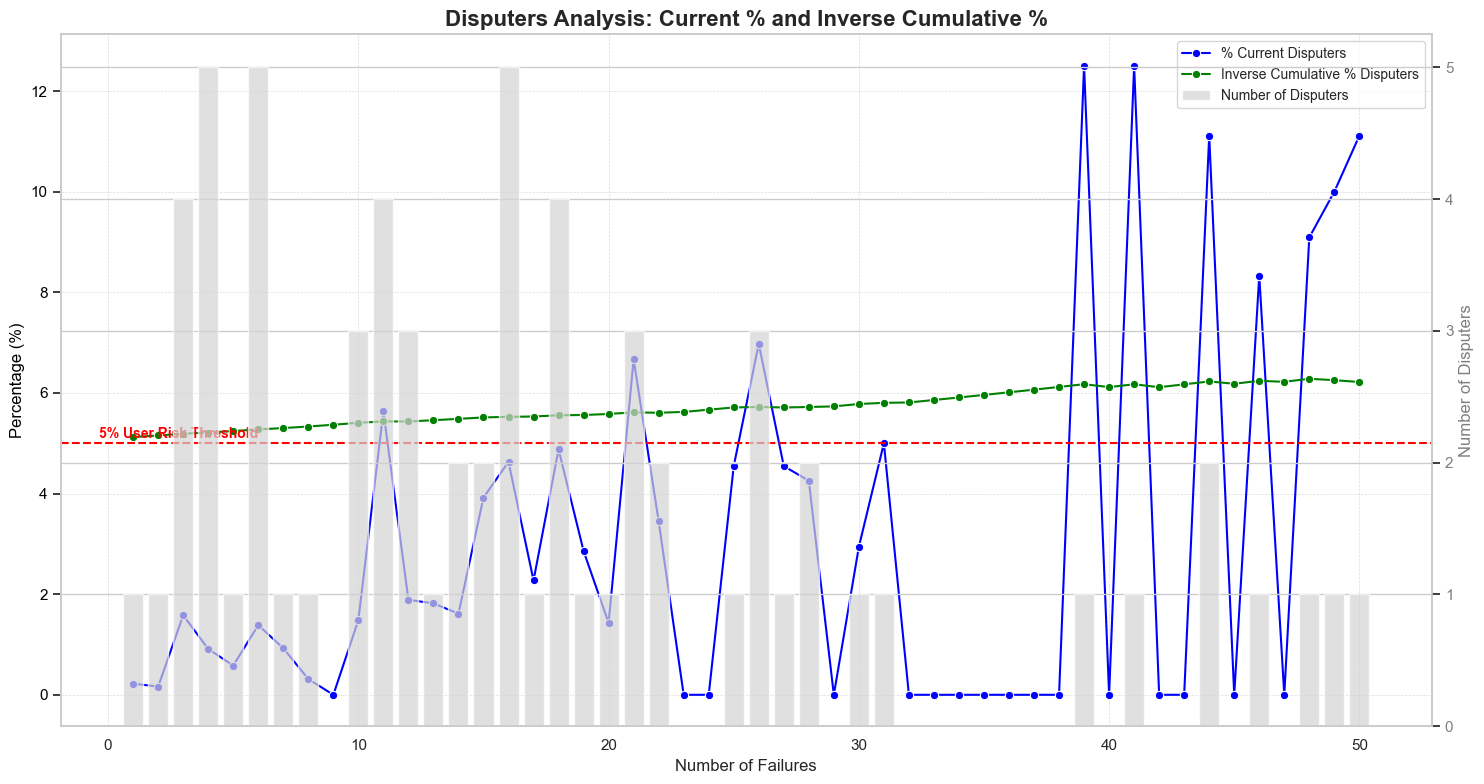

In [120]:
# Adjusting the plot to include a secondary axis for the bars

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis for percentages
ax2 = ax1.twinx()

# Bar plot for number of users (on secondary axis)
ax2.bar(dispute_freq_grouped['num_failures'], dispute_freq_grouped['num_users'], color='lightgrey', alpha=0.7, label='Number of Disputers', width=0.8)

# Line plot for current % (on primary axis)
sns.lineplot(x='num_failures', y=dispute_freq_grouped['disputes_d30_binary']*100, marker='o', color='blue', label='% Current Disputers', ax=ax1, data=dispute_freq_grouped)

# Line plot for inverse cumulative % (on primary axis)
sns.lineplot(x='num_failures', y='inverse_cumulative_percentage', marker='o', color='green', label='Inverse Cumulative % Disputers', ax=ax1, data=dispute_freq_grouped)

# Add horizontal threshold line on primary axis
ax1.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.text(6, 5.05, "5% User Risk Threshold", color='red', fontsize=10, ha='right', va='bottom', weight='bold')

# Titles and labels
ax1.set_title("Disputers Analysis: Current % and Inverse Cumulative %", fontsize=16, weight='bold')
ax1.set_xlabel("Number of Failures", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color='black')
ax2.set_ylabel("Number of Disputers", fontsize=12, color='grey')

# Setting axis colors for clarity
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='grey')

# Adding grid for better readability
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

# Tight layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


### Segmentation of types

I want a piece of code that 

In [50]:
non_disputers_df[non_disputers_df['first_pay_time'] >= '2024-10-15']

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,payment_fail_history,payment_fail_history_time,payment_history,payment_history_time,disputes_d30_binary,num_failures
19,50321477,50321477,0,com.reelsflight.newb,0,[None],NaN,2024-10-19 10:19:48.077,1896,[start_pack],[1],[None],[9.3],[2024-10-19 10:19:48.077],0,1.0
167,50541274,50541274,0,com.coincyclone.casi,0,"[funds, ]",NaN,2024-10-19 11:46:05.441,491,[first],"[1, 1]","[2024-10-19 11:45:29.515, 2024-10-19 11:45:28....",[0.75],[2024-10-19 11:46:05.441],0,2.0
185,50615867,50615867,0,com.richesflow.casino,0,[None],NaN,2024-10-18 19:13:19.592,69,"[money_return, first]",[1],[None],"[3.6614, 0.7751]","[2024-10-18 19:13:19.592, 2024-10-18 19:20:34....",0,1.0
186,50617453,50617453,0,com.richesflow.casino,0,[None],NaN,2024-10-18 04:39:52.645,24,[first],[1],[None],[0.8535],[2024-10-18 04:39:52.645],0,1.0
187,50628862,50628862,0,com.richesflow.casino,0,[None],NaN,2024-10-22 08:20:58.744,0,[halloween_charge],[1],[None],[9.99],[2024-10-22 08:20:58.744],0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314819,50609138,50609138,0,com.bblitz.casino.rio,0,[None],NaN,2024-10-18 07:27:40.451,185,[first],[1],[None],[0.75],[2024-10-18 07:27:40.451],0,1.0
314822,50617014,50617014,0,com.richesflow.casino,0,"[invalid, invalid, invalid, invalid]",NaN,2024-10-18 01:00:07.937,26,"[money_return, first, halloween_charge]","[1, 1, 1, 1]","[2024-10-23 23:32:50.358, 2024-10-23 23:32:48....","[2.7605, 0.8535, 9.2905]","[2024-10-18 01:00:07.937, 2024-10-23 23:32:25....",0,4.0
314823,50619966,50619966,0,com.richesflow.casino,0,[None],NaN,2024-10-18 19:03:14.079,0,"[halloween_charge, first, inbox_first_offer]",[1],[None],"[9.425465, 0.8535, 9.425465]","[2024-10-18 19:03:14.079, 2024-10-21 11:30:06....",0,1.0
314824,50620933,50620933,0,com.richesflow.casino,0,"[fraud, fraud]",NaN,2024-10-19 03:47:52.770,0,"[default, sub_pack, start_pack, first, default...","[1, 1]","[2024-10-20 10:43:44.185, 2024-10-20 10:43:45....","[4.6675, 6.5745, 9.3, 0.75, 4.6675, 9.3]","[2024-10-20 08:43:29.965, 2024-10-20 06:27:46....",0,2.0


In [51]:
# Step 1: Extract unique strings across all lists
unique_strings = set(item for sublist in non_disputers_df[non_disputers_df['first_pay_time'] >= '2024-10-15']['fail_type_payment_type_history'] for item in sublist)

# Step 2: Analyze each unique string
types_agg = []
for unique_str in unique_strings:
    filtered_rows = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].apply(lambda x: unique_str in x)]
    filtered_rows = filtered_rows[filtered_rows['num_failures'] >= 10]
    avg_disputes = filtered_rows['disputes_d30_binary'].mean() if not filtered_rows.empty else 0
    count_rows = filtered_rows.shape[0]
    types_agg.append({'fail_type': unique_str, 'average_disputes_d30_binary': avg_disputes, 'count': count_rows})

# Step 3: Convert results to a DataFrame
types_agg_df = pd.DataFrame(types_agg)

In [60]:
types_agg_df[types_agg_df['count'] >= 1000].sort_values('average_disputes_d30_binary', ascending = False)
unique_strings = types_agg_df[types_agg_df['count'] >= 400]['fail_type'].unique()
unique_strings

array(['', '3d', 'funds', 'invalid', 'honor', 'fraud', 'risk',
       'violation', 'auth', 'card', 'limit', 'account', 'decline'],
      dtype=object)

In [201]:
print('Check the dispute rate for each fail type based on ferquency')

ranges = {
    'failures_1': lambda x: x == 1,
    'failures_2_to_5': lambda x: 2 <= x <= 5,
    'failures_6_to_15': lambda x: 11 <= x <= 15,
    'failures_16_to_30': lambda x: 16 <= x <= 30,
    'failures_greater_than_30': lambda x: x > 30
}

# Initialize a dictionary to store results
ranges_data_dict = {fail_type: {range_label: {'average_disputes': 0, 'count': 0} for range_label in ranges.keys()} for fail_type in unique_strings}

# Analyze each unique string and range
for unique_str in unique_strings:
    for range_label, range_condition in ranges.items():
        filtered_rows = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].apply(lambda x: unique_str in x)]
        filtered_rows = filtered_rows[filtered_rows['num_failures'].apply(range_condition)]
        avg_disputes = filtered_rows['disputes_d30_binary'].mean() if not filtered_rows.empty else 0
        count_rows = filtered_rows.shape[0]
        ranges_data_dict[unique_str][range_label] = {'average_disputes': avg_disputes, 'count': count_rows}


Check the dispute rate for each fail type based on ferquency


In [202]:
# Convert the results to a DataFrame for better presentation
columns = []
for range_label in ranges.keys():
    columns.append(f'{range_label}_avg_disputes')
    columns.append(f'{range_label}_count')

table_data = []
for fail_type, data in ranges_data_dict.items():
    row = {'fail_type': fail_type}
    for range_label in ranges.keys():
        row[f'{range_label}_avg_disputes'] = data[range_label]['average_disputes']
        row[f'{range_label}_count'] = data[range_label]['count']
    table_data.append(row)

complex_results_df = pd.DataFrame(table_data)
complex_results_df

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_15_avg_disputes,failures_6_to_15_count,failures_16_to_30_avg_disputes,failures_16_to_30_count,failures_greater_than_30_avg_disputes,failures_greater_than_30_count
0,,0.004963,403,0.008854,12988,0.020321,1870,0.025933,2545,0.049555,1574
1,3d,0.013072,153,0.017378,633,0.036667,300,0.046256,454,0.048951,429
2,funds,0.004269,937,0.008449,8877,0.022825,1621,0.026455,2268,0.054496,1468
3,invalid,0.005780,173,0.007246,1242,0.028902,346,0.037665,531,0.050398,377
4,honor,0.000000,8,0.000000,387,0.017699,113,0.045455,198,0.039735,151
5,fraud,0.010309,388,0.015074,4710,0.032355,1329,0.038314,2088,0.055480,1478
6,risk,0.000000,51,0.006289,3657,0.020683,967,0.018392,1468,0.045155,1063
7,violation,0.000000,10,0.003509,285,0.015038,133,0.017778,225,0.075472,212
8,auth,0.000000,18,0.008919,897,0.045872,218,0.043367,392,0.053512,299
9,card,0.000000,162,0.007576,2772,0.027375,621,0.022412,937,0.055233,688


In [203]:
# Pivot to long format for easier manipulation
df_long = complex_results_df.melt(id_vars=["fail_type"], var_name="metric", value_name="value")

# Extract "avg_disputes" or "count" from metrics
df_long["type"] = df_long["metric"].apply(lambda x: "Disputer rate %" if "avg_disputes" in x else "Count cases")
df_long["period"] = df_long["metric"].str.replace("_avg_disputes", "").str.replace("_count", "")
df_long = df_long[~df_long['period'].isin(['failure_flag', 'total_failures'])]

# Pivot into the desired format
df_pivoted = df_long.pivot_table(
    index=["fail_type", "period"],
    columns="type",
    values="value",
    aggfunc="first"
).reset_index()

df_pivoted['period'].unique()

array(['failures_1', 'failures_16_to_30', 'failures_2_to_5',
       'failures_6_to_15', 'failures_greater_than_30'], dtype=object)

In [200]:
df_pivoted["failure frequency"].unique()

['[2, 5)', '[6, 15)', '[16, 30)', '>30', NaN]
Categories (5, object): ['1' < '[2, 5)' < '[6, 15)' < '[16, 30)' < '>30']

In [204]:
# Update the "period" to reflect failure frequency ranges
def update_failure_frequency(period):
    if "failures_6_to_15" in period:
        return "[6, 15)"
    elif "failures_2_to_5" in period:
        return "[2, 5)"
    elif "failures_16_to_30" in period:
        return "[16, 30)"
    elif "failures_1" in period:
        return "[1, 1)"
    elif "failures_greater_than_30" in period:
        return ">30"
    else:
        return "Unknown"

df_pivoted["failure frequency"] = df_pivoted["period"].apply(update_failure_frequency)

# Rearrange columns for better readability
df_pivoted = df_pivoted.rename(columns={"Count cases": "Number of cases", "Disputer rate %": "Dispute rate %"})
df_pivoted = df_pivoted[["fail_type", "failure frequency", "Number of cases", "Dispute rate %"]]

df_pivoted['failure frequency'].unique()


# Define the desired order for the "failure frequency" column
frequency_order = ['1', '[2, 5)', '[6, 15)', '[16, 30)', '>30']

# Apply the order to sort the data
df_pivoted["failure frequency"] = pd.Categorical(df_pivoted["failure frequency"], categories=frequency_order, ordered=True)
df_pivoted = df_pivoted.sort_values(by=["fail_type", "failure frequency"]).reset_index(drop=True)

In [205]:
df_pivoted[df_pivoted['fail_type'] == 'funds'].dropna()

type,fail_type,failure frequency,Number of cases,Dispute rate %
35,funds,"[2, 5)",8877.0,0.008449
36,funds,"[6, 15)",1621.0,0.022825
37,funds,"[16, 30)",2268.0,0.026455
38,funds,>30,1468.0,0.054496


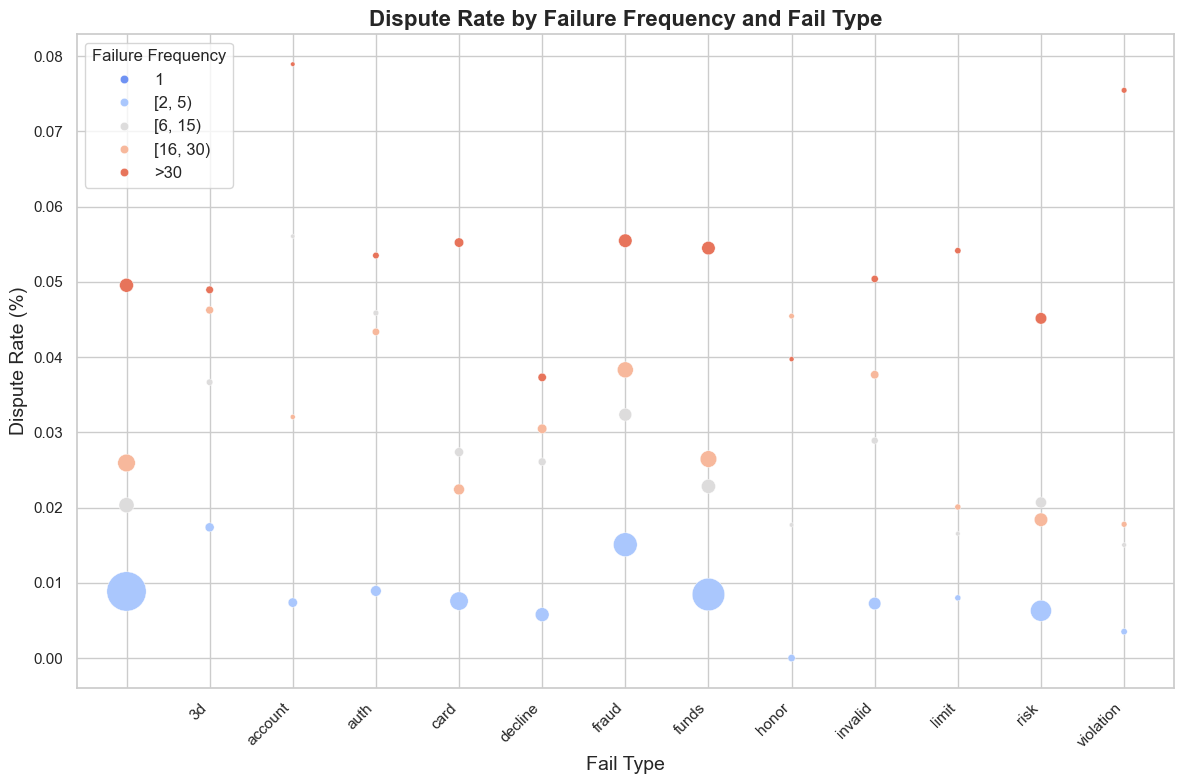

In [199]:
# Set a professional and clean style
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_pivoted.dropna(),
    x='fail_type',
    y='Dispute rate %',
    hue='failure frequency',  # Color by failure frequency
    size='Number of cases',   # Size by the number of cases
    sizes=(10, 800),          # Adjust size range
    legend="full",            # Display full legend
    palette="coolwarm",       # Use a professional color palette
)

# Set plot title and labels
plt.title('Dispute Rate by Failure Frequency and Fail Type', fontsize=16, weight='bold')
plt.xlabel('Fail Type', fontsize=14)
plt.ylabel('Dispute Rate (%)', fontsize=14)

# Customize the legend to only show failure frequency (exclude Number of Cases)
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:6], labels=labels[1:6], title="Failure Frequency", loc="upper left", fontsize=12)

# Adjust the x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

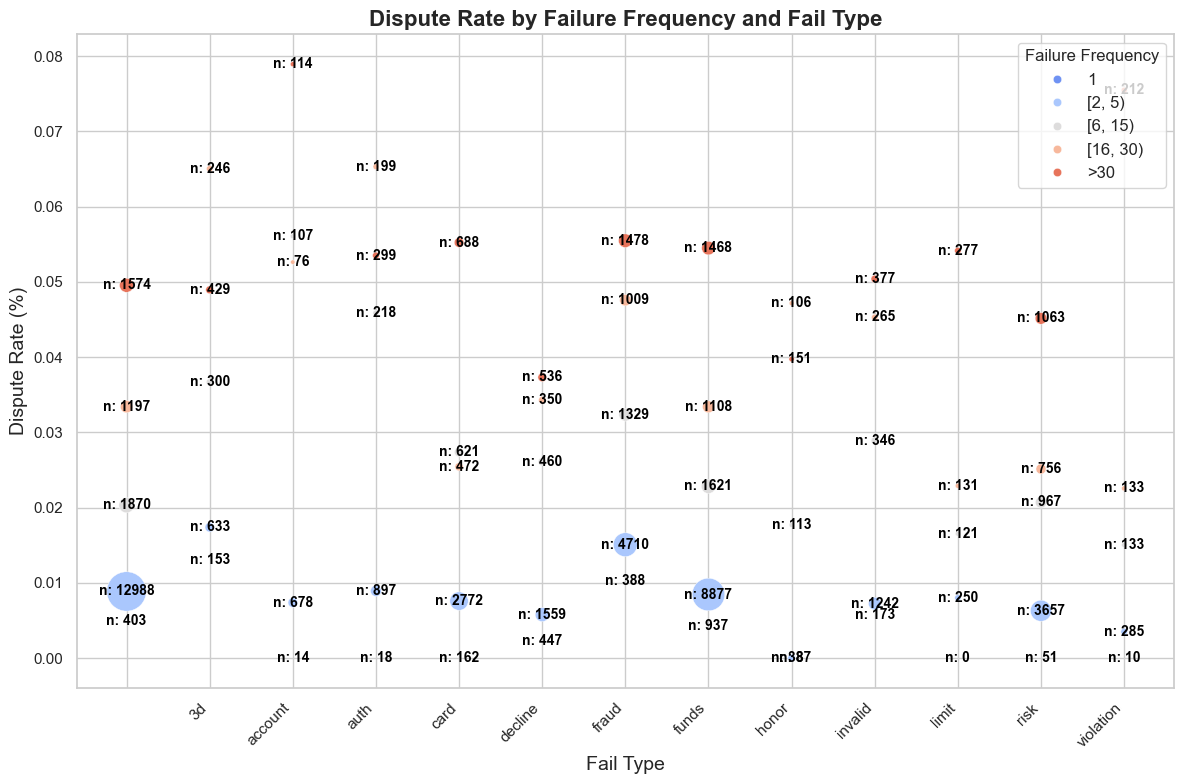

In [189]:
# Set a professional and clean style
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_pivoted.dropna(),
    x='fail_type',
    y='Dispute rate %',
    hue='failure frequency',  # Color by failure frequency
    size='Number of cases',   # Size by the number of cases
    sizes=(10, 800),          # Adjust size range
    legend="full",            # Display full legend
    palette="coolwarm",       # Use a professional color palette
)

# Add labels with the number of cases in the format f'n: {k}'
for i in range(df_pivoted.shape[0]):
    plt.text(
        df_pivoted['fail_type'].iloc[i], 
        df_pivoted['Dispute rate %'].iloc[i], 
        f"n: {df_pivoted['Number of cases'].astype(int).iloc[i]}", 
        ha='center', 
        va='center', 
        fontsize=10, 
        color='black', 
        weight='bold'
    )

# Set plot title and labels
plt.title('Dispute Rate by Failure Frequency and Fail Type', fontsize=16, weight='bold')
plt.xlabel('Fail Type', fontsize=14)
plt.ylabel('Dispute Rate (%)', fontsize=14)

# Customize the legend to only show failure frequency (exclude Number of Cases)
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:6], labels=labels[1:], title="Failure Frequency", loc="upper right", fontsize=12)

# Adjust the x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

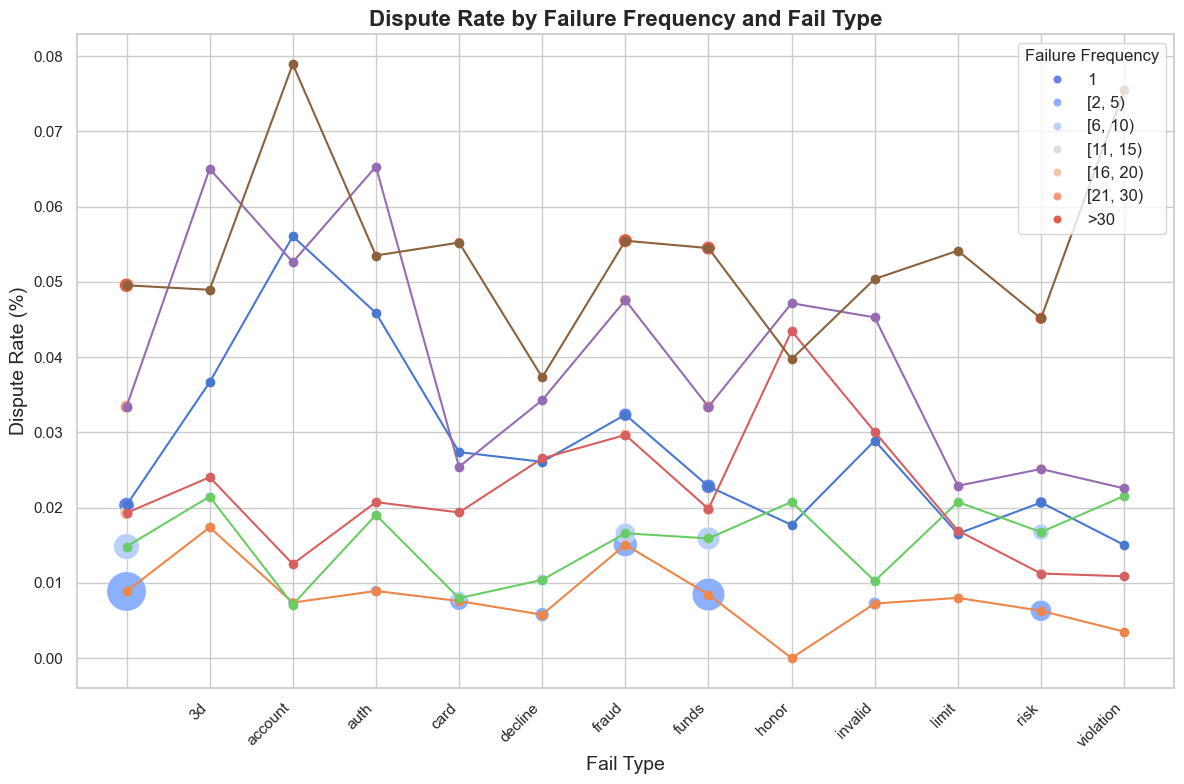

In [157]:
# Set a professional and clean style
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_pivoted.dropna(),
    x='fail_type',
    y='Dispute rate %',
    hue='failure frequency',  # Color by failure frequency
    size='Number of cases',   # Size by the number of cases
    sizes=(10, 800),          # Adjust size range
    legend="full",            # Display full legend
    palette="coolwarm",       # Use a professional color palette
)

# Add lines connecting the points based on the 'failure frequency' category
for freq in df_pivoted['failure frequency'].unique():
    freq_data = df_pivoted[df_pivoted['failure frequency'] == freq]
    # Sort by fail_type to ensure lines are drawn correctly along the x-axis
    freq_data = freq_data.sort_values(by='fail_type')
    plt.plot(freq_data['fail_type'], freq_data['Dispute rate %'], marker='o', linestyle='-', label=f'{freq} frequency')

# Set plot title and labels
plt.title('Dispute Rate by Failure Frequency and Fail Type', fontsize=16, weight='bold')
plt.xlabel('Fail Type', fontsize=14)
plt.ylabel('Dispute Rate (%)', fontsize=14)

# Customize the legend to only show failure frequency (exclude Number of Cases)
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:8], labels=labels[1:8], title="Failure Frequency", loc="upper right", fontsize=12)

# Adjust the x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [73]:
df_pivoted

x - axist
failure frequency - color 
Number of cases - dot size 
Dispute rate % 

type,fail_type,failure frequency,Number of cases,Dispute rate %
0,,1,1870.0,0.020321
1,,"[2, 5)",12988.0,0.008854
2,,"[6, 10)",5465.0,0.014822
3,,"[11, 15)",403.0,0.004963
4,,"[11, 15)",1348.0,0.019288
...,...,...,...,...
86,violation,"[6, 10)",232.0,0.021552
87,violation,"[11, 15)",10.0,0.000000
88,violation,"[11, 15)",92.0,0.010870
89,violation,NaN,133.0,0.022556


### Creation of others

This is put on hold because I don't think it is necessary

In order to create others, you need to start again properly. 

In [ ]:
# Step 1: Add total_failures_count to complex_results_df
complex_results_df['total_failures_count'] = complex_results_df[[
    "failures_1_count",
    "failures_2_to_5_count",
    "failures_6_to_10_count",
    "failures_11_to_15_count",
    "failures_greater_than_15_count",
]].sum(axis=1)

# Identify rows to merge into "Others"
others_complex = complex_results_df[complex_results_df['total_failures_count'] < 50]
merged_others = others_complex[[
    "failures_1_avg_disputes",
    "failures_1_count",
    "failures_2_to_5_avg_disputes",
    "failures_2_to_5_count",
    "failures_6_to_10_avg_disputes",
    "failures_6_to_10_count",
    "failures_11_to_15_avg_disputes",
    "failures_11_to_15_count",
    "failures_greater_than_15_avg_disputes",
    "failures_greater_than_15_count",
]].sum()

others_complex

In [ ]:
# Replace unique strings by others
# Then if others, then merge 

In [ ]:
ranges = {
    'failures_1': lambda x: x == 1,
    'failures_2_to_5': lambda x: 2 <= x <= 5,
    'failures_6_to_10': lambda x: 6 <= x <= 10,
    'failures_11_to_15': lambda x: 11 <= x <= 15,
    'failures_greater_than_15': lambda x: x > 15
}

# Initialize a dictionary to store results
complex_results = {fail_type: {range_label: {'average_disputes': 0, 'count': 0} for range_label in ranges.keys()} for fail_type in unique_strings}

# Analyze each unique string and range
for unique_str in unique_strings:
    for range_label, range_condition in ranges.items():
        filtered_rows = non_disputers_df[non_disputers_df['fail_type_payment_type_history'].apply(lambda x: unique_str in x)]
        filtered_rows = filtered_rows[filtered_rows['num_failures'].apply(range_condition)]
        avg_disputes = filtered_rows['disputes_d30_binary'].mean() if not filtered_rows.empty else 0
        count_rows = filtered_rows.shape[0]
        complex_results[unique_str][range_label] = {'average_disputes': avg_disputes, 'count': count_rows}

# Convert the results to a DataFrame for better presentation
columns = []
for range_label in ranges.keys():
    columns.append(f'{range_label}_avg_disputes')
    columns.append(f'{range_label}_count')

table_data = []
for fail_type, data in complex_results.items():
    row = {'fail_type': fail_type}
    for range_label in ranges.keys():
        row[f'{range_label}_avg_disputes'] = data[range_label]['average_disputes']
        row[f'{range_label}_count'] = data[range_label]['count']
    table_data.append(row)

complex_results_df = pd.DataFrame(table_data)
complex_results_df

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count
0,,0.004963,403,0.008854,12988,0.014822,5465,0.020321,1870,0.034960,4119
1,retry,0.000000,2,0.142857,7,0.000000,7,0.000000,1,0.000000,7
2,fraud,0.010309,388,0.015074,4710,0.016586,3316,0.032355,1329,0.045429,3566
3,honor,0.000000,8,0.000000,387,0.020761,289,0.017699,113,0.042980,349
4,limit,0.000000,0,0.008000,250,0.020747,241,0.016529,121,0.038023,526
5,issuer,0.000000,3,0.008000,250,0.008696,115,0.061224,49,0.074324,148
6,unknown,0.000000,2,0.000000,0,1.000000,1,0.000000,1,1.000000,1
7,account,0.000000,14,0.007375,678,0.007117,281,0.056075,107,0.051852,270
8,auth,0.000000,18,0.008919,897,0.019031,578,0.045872,218,0.047757,691
9,risk,0.000000,51,0.006289,3657,0.016746,2090,0.020683,967,0.029633,2531


In [57]:
# Add the merged "Others" row to the DataFrame using concat
merged_others_row = pd.DataFrame([{"fail_type": "Others", **merged_others}])

others_complex['fail_type'] = 'Others'
others_complex.groupby('fail_type')[others_complex.columns[1:]].sum().reset_index(drop = False)

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count
0,Others,0.0,6,0.142857,16,1.0,14,0.0,6,1.071429,22,64


In [59]:
# complex_results_df = pd.concat(
#     [complex_results_df[complex_results_df['total_failures_count'] >= 50], merged_others_row],
#     ignore_index = True,
# )

# merged_others_row

In [60]:
# Step 1: Add total_failures_count to complex_results_df
complex_results_df['total_failures_count'] = complex_results_df[[
    "failures_1_count",
    "failures_2_to_5_count",
    "failures_6_to_10_count",
    "failures_11_to_15_count",
    "failures_greater_than_15_count",
]].sum(axis=1)

# Identify rows to merge into "Others"
others_complex = complex_results_df[complex_results_df['total_failures_count'] < 50]
merged_others = others_complex[[
    "failures_1_avg_disputes",
    "failures_1_count",
    "failures_2_to_5_avg_disputes",
    "failures_2_to_5_count",
    "failures_6_to_10_avg_disputes",
    "failures_6_to_10_count",
    "failures_11_to_15_avg_disputes",
    "failures_11_to_15_count",
    "failures_greater_than_15_avg_disputes",
    "failures_greater_than_15_count",
]].sum()

# Add the merged "Others" row to the DataFrame using concat
merged_others_row = pd.DataFrame([{"fail_type": "Others", **merged_others}])
complex_results_df = pd.concat(
    [complex_results_df[complex_results_df['total_failures_count'] >= 50], merged_others_row],
    ignore_index = True,
)

# Step 2: Filter rows where any failure column reaches 6% with a count >= 3
failure_columns = [
    ("failures_1_avg_disputes", "failures_1_count"),
    ("failures_2_to_5_avg_disputes", "failures_2_to_5_count"),
    ("failures_6_to_10_avg_disputes", "failures_6_to_10_count"),
    ("failures_11_to_15_avg_disputes", "failures_11_to_15_count"),
    ("failures_greater_than_15_avg_disputes", "failures_greater_than_15_count"),
]

result = []
for _, row in complex_results_df.iterrows():
    for avg_col, count_col in failure_columns:
        if row[avg_col] >= 0.06 and row[count_col] >= 3:
            result.append(row)
            break

result_df_complex = pd.DataFrame(result).reset_index(drop=True)
result_df_complex

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count
0,issuer,0.0,3.0,0.008000,250.0,0.008696,115.0,0.061224,49.0,0.074324,148.0,565.0
1,inner_risk_control,0.0,40.0,0.000000,45.0,0.032258,31.0,0.136364,22.0,0.086331,139.0,277.0
2,timeout,0.0,48.0,0.012195,82.0,0.054545,55.0,0.055556,36.0,0.086538,104.0,325.0
3,pick,0.0,3.0,0.000000,40.0,0.031250,32.0,0.083333,12.0,0.114286,35.0,122.0
4,black,0.0,3.0,0.004310,232.0,0.012500,160.0,0.043478,69.0,0.080808,198.0,662.0
5,Others,0.0,6.0,0.142857,16.0,1.000000,14.0,0.000000,6.0,1.071429,22.0,NaN


I want to find cases where we reach 6% in the failure columns, with a count >= 3. Also before that those rows there the sum of each failures count does not reach 50 should be merged into a faily_type 'Others' 

In [61]:
# Flagging the period in which 6% was reached for each row
def flag_failure_period(row, failure_columns):
    for avg_col, count_col, period in failure_columns:
        if row[avg_col] >= 0.06 and row[count_col] >= 3:
            return period
    return "Never"

# Update failure_columns to include period names
failure_columns = [
    ("failures_1_avg_disputes", "failures_1_count", "1"),
    ("failures_2_to_5_avg_disputes", "failures_2_to_5_count", ">1"),
    ("failures_6_to_10_avg_disputes", "failures_6_to_10_count", ">5"),
    ("failures_11_to_15_avg_disputes", "failures_11_to_15_count", ">10"),
    ("failures_greater_than_15_avg_disputes", "failures_greater_than_15_count", ">15"),
]

# Apply the function to flag periods
complex_results_df['failure_flag'] = complex_results_df.apply(
    flag_failure_period, axis=1, failure_columns=failure_columns
)

complex_results_df

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count,failure_flag
0,,0.004963,403.0,0.008854,12988.0,0.014822,5465.0,0.020321,1870.0,0.034960,4119.0,24845.0,Never
1,fraud,0.010309,388.0,0.015074,4710.0,0.016586,3316.0,0.032355,1329.0,0.045429,3566.0,13309.0,Never
2,honor,0.000000,8.0,0.000000,387.0,0.020761,289.0,0.017699,113.0,0.042980,349.0,1146.0,Never
3,limit,0.000000,0.0,0.008000,250.0,0.020747,241.0,0.016529,121.0,0.038023,526.0,1138.0,Never
4,issuer,0.000000,3.0,0.008000,250.0,0.008696,115.0,0.061224,49.0,0.074324,148.0,565.0,>10
5,account,0.000000,14.0,0.007375,678.0,0.007117,281.0,0.056075,107.0,0.051852,270.0,1350.0,Never
6,auth,0.000000,18.0,0.008919,897.0,0.019031,578.0,0.045872,218.0,0.047757,691.0,2402.0,Never
7,risk,0.000000,51.0,0.006289,3657.0,0.016746,2090.0,0.020683,967.0,0.029633,2531.0,9296.0,Never
8,decline,0.002237,447.0,0.005773,1559.0,0.010397,1058.0,0.026087,460.0,0.033469,1225.0,4749.0,Never
9,card,0.000000,162.0,0.007576,2772.0,0.007963,1507.0,0.027375,621.0,0.036308,1625.0,6687.0,Never


In [64]:
# complex_results_df[complex_results_df['failure_flag'] == 'Never']
complex_results_df[complex_results_df['failure_flag'] == '>15']

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count,failure_flag
15,timeout,0.0,48.0,0.012195,82.0,0.054545,55.0,0.055556,36.0,0.086538,104.0,325.0,>15
21,black,0.0,3.0,0.004310,232.0,0.012500,160.0,0.043478,69.0,0.080808,198.0,662.0,>15


In [183]:
complex_results_df[complex_results_df['failure_flag'] == '>10']

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count,failure_flag
9,3d,0.0,0.0,0.04,50.0,0.000000,89.0,0.084746,59.0,0.051587,252.0,450.0,>10
14,honor,0.0,0.0,0.00,6.0,0.027027,37.0,0.062500,16.0,0.072289,83.0,142.0,>10
15,Others,0.0,0.0,0.00,7.0,0.000000,25.0,0.333333,22.0,1.440277,107.0,NaN,>10


In [207]:
complex_results_df[complex_results_df['failure_flag'] == '>15']['fail_type'].unique()
complex_results_df[complex_results_df['failure_flag'] == '>10']

,fail_type,failures_1_avg_disputes,failures_1_count,failures_2_to_5_avg_disputes,failures_2_to_5_count,failures_6_to_10_avg_disputes,failures_6_to_10_count,failures_11_to_15_avg_disputes,failures_11_to_15_count,failures_greater_than_15_avg_disputes,failures_greater_than_15_count,total_failures_count,failure_flag
9,3d,0.0,0.0,0.04,50.0,0.000000,89.0,0.084746,59.0,0.051587,252.0,450.0,>10
14,honor,0.0,0.0,0.00,6.0,0.027027,37.0,0.062500,16.0,0.072289,83.0,142.0,>10
15,Others,0.0,0.0,0.00,7.0,0.000000,25.0,0.333333,22.0,1.440277,107.0,NaN,>10


In [ ]:
# Pivot to long format for easier manipulation
df_long = complex_results_df[complex_results_df['failure_flag'] == '>10'].melt(id_vars=["fail_type"], var_name="metric", value_name="value")

# Extract "avg_disputes" or "count" from metrics
df_long["type"] = df_long["metric"].apply(lambda x: "Disputer rate %" if "avg_disputes" in x else "Count cases")
df_long["period"] = df_long["metric"].str.replace("_avg_disputes", "").str.replace("_count", "")
df_long = df_long[~df_long['period'].isin(['failure_flag', 'total_failures'])]

# Pivot into the desired format
df_pivoted = df_long.pivot_table(
    index=["fail_type", "period"],
    columns="type",
    values="value",
    aggfunc="first"
).reset_index()


In [52]:
df_pivoted

NameError: name 'df_pivoted' is not defined

In [204]:
# Update the "period" to reflect failure frequency ranges
def update_failure_frequency(period):
    if "failures_11_to_15" in period:
        return "1"
    elif "failures_2_to_5" in period:
        return "[2, 5)"
    elif "failures_6_to_10" in period:
        return "[6, 10)"
    elif "failures_1" in period:
        return "[11, 15)"
    elif "failures_greater_than_15" in period:
        return ">15"
    else:
        return "Unknown"

df_pivoted["failure frequency"] = df_pivoted["period"].apply(update_failure_frequency)

# Rearrange columns for better readability
df_pivoted = df_pivoted.rename(columns={"Count cases": "Number of cases", "Disputer rate %": "Dispute rate %"})
df_pivoted = df_pivoted[["fail_type", "failure frequency", "Number of cases", "Dispute rate %"]]

df_pivoted['failure frequency'].unique()


array(['[11, 15)', '1', '[2, 5)', '[6, 10)', '>15'], dtype=object)

In [ ]:


# Define the desired order for the "failure frequency" column
frequency_order = ['1', '[2, 5)', '[6, 10)', '[11, 15)', '>15']

# Apply the order to sort the data
df_pivoted["failure frequency"] = pd.Categorical(df_pivoted["failure frequency"], categories=frequency_order, ordered=True)
df_pivoted = df_pivoted.sort_values(by=["fail_type", "failure frequency"]).reset_index(drop=True)

In [206]:
df_pivoted

type,fail_type,failure frequency,Number of cases,Dispute rate %
0,3d,1,59.0,0.084746
1,3d,"[2, 5)",50.0,0.04
2,3d,"[6, 10)",89.0,0.0
3,3d,"[11, 15)",0.0,0.0
4,3d,>15,252.0,0.051587
5,Others,1,22.0,0.333333
6,Others,"[2, 5)",7.0,0.0
7,Others,"[6, 10)",25.0,0.0
8,Others,"[11, 15)",0.0,0.0
9,Others,>15,107.0,1.440277


### My next step

I have to include the further information into the dataset. 

In [207]:
non_disputers_df

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,payment_fail_history,payment_fail_history_time,payment_history,payment_history_time,disputes_d30_binary,num_failures
0,98051571,98051571,0,com.dogiedash.burst,0,[None],NaN,2024-09-22 02:15:50.604,0,"[default, default]",[1],[None],"[19.24, 4.73]","[2024-09-22 02:32:39.454, 2024-09-22 02:15:50....",0,1.0
1,10034226,10034226,0,com.acorncasino.slots,0,[None],NaN,2024-07-19 20:19:40.532,5898,[cash_back],[1],[None],[0.8541],[2024-07-19 20:19:40.532],0,1.0
2,10038622,10038622,0,com.acorncasino.slots,0,[None],NaN,2024-07-03 18:55:37.906,5418,[default],[1],[None],[4.435],[2024-07-03 18:55:37.906],0,1.0
3,50154002,50154002,0,com.whiskers.goldslots,0,[None],NaN,2024-09-22 19:53:18.758,2951,"[cash_back, start_pack]",[1],[None],"[0.7751, 4.6235]","[2024-09-22 19:55:00.371, 2024-09-22 19:53:18....",0,1.0
4,50163300,50163300,0,com.whiskers.goldslots,0,[None],NaN,2024-07-01 00:45:10.162,852,"[default, default, default, default, default, ...",[1],[None],"[9.434, 9.434, 9.434, 9.434, 9.434, 9.434, 19....","[2024-07-06 22:14:19.885, 2024-07-07 01:30:35....",0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314853,40491350,40491350,0,com.prudentprophet.jackpotspinning777,0,[None],NaN,2024-07-02 14:23:16.769,2,"[default, default, default, start_pack, defaul...",[1],[None],"[4.48, 4.48, 18.82, 4.48, 18.82, 3.52, 3.498, ...","[2024-07-06 13:39:29.637, 2024-07-05 07:40:11....",0,1.0
314854,40492403,40492403,0,com.asselin.android.jackpotlegends,0,[None],NaN,2024-07-03 00:41:35.110,0,[start_pack],[1],[None],[4.435],[2024-07-03 00:41:35.110],0,1.0
314855,40497719,40497719,0,com.prudentprophet.jackpotspinning777,0,[None],NaN,2024-07-05 22:47:59.328,0,"[first_b, default, start_pack, start_pack, def...",[1],[None],"[22.53, 18.72, 47.25, 13.97, 47.25, 78.64, 2.5...","[2024-07-09 00:01:08.782, 2024-07-08 01:25:59....",0,1.0
314856,40517107,40517107,0,com.asselin.android.luckylegends,0,[None],NaN,2024-07-13 20:47:49.192,14,[first_b],[1],[None],[2.57],[2024-07-13 20:47:49.192],0,1.0


In [208]:
non_disputers_df.sample(3000).to_csv('non_disputers_df.csv')

In [155]:
result = non_disputers_df.groupby('failed').agg(
    sum_disputes = ('disputes_d30_binary', 'sum'),
    avg_disputes = ('disputes_d30_binary', 'mean')
).reset_index().sort_values(by = 'sum_disputes', ascending = False)

result

,failed,sum_disputes,avg_disputes
0,0,1058,0.003412
1,1,132,0.044385


- OBTAIN THE DISPUTER RATES BY bundle_id
- FILTER FOR PEOPLE WHO HAVE NOT DISPUTED YET 

-  

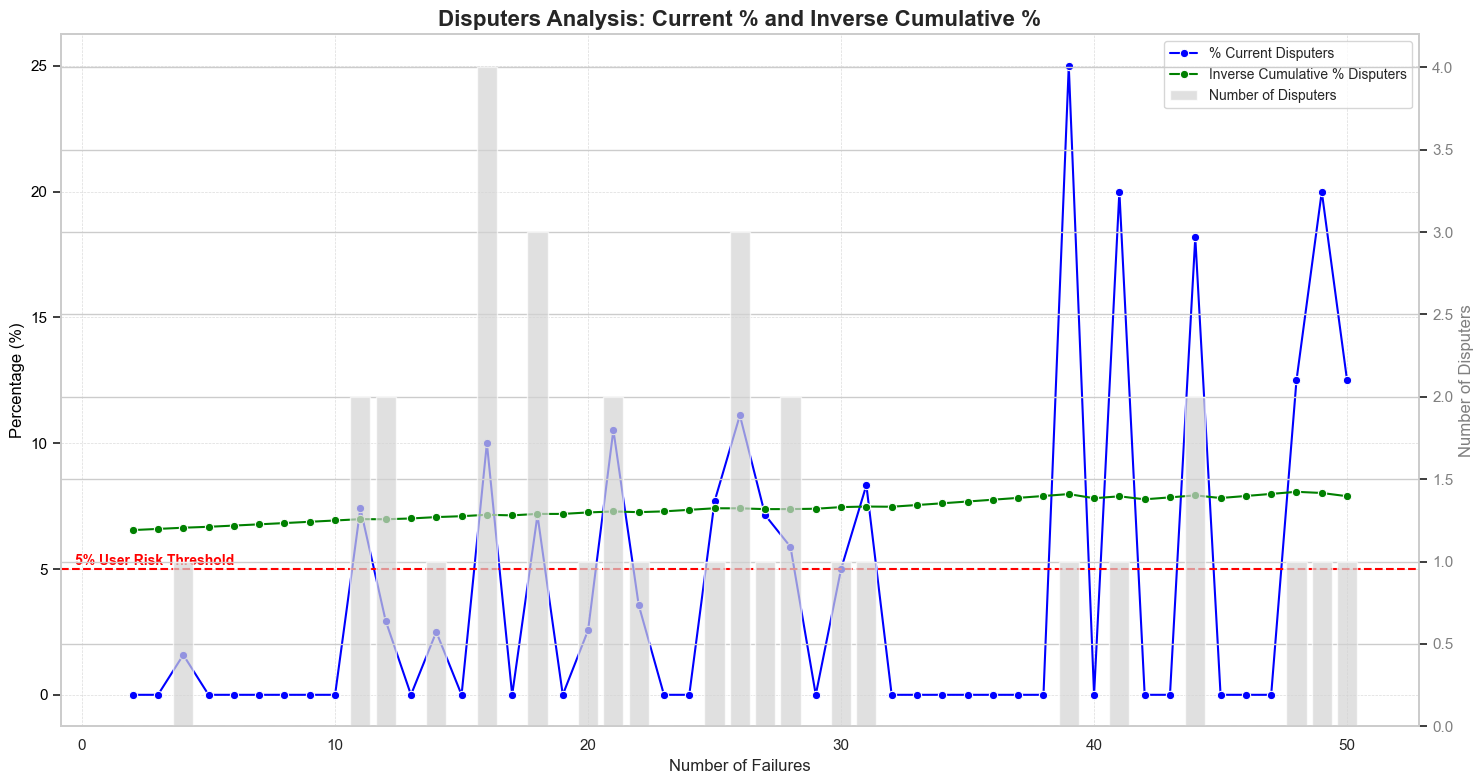

# Analyse the frequency of each other case

Get the count of each unique case in each 

In [244]:
# Extract the unique

# Define the list of failure types, including 'empty_string' for ''
failure_types = ['', '3d', 'funds', 'invalid', 'honor', 'fraud', 'risk', 'violation', 'auth', 'card', 'limit', 'account', 'decline']
failure_types = ['empty_string'] + failure_types[1:]  # Replace '' with 'empty_string'

# Create a column for each failure type
for failure_type in failure_types:
    non_disputers_df[f'count_{failure_type}'] = non_disputers_df['fail_type_payment_type_history'].apply(lambda x: x.count(failure_type))

# Generate the column names
failure_type_names = [f'count_{failure_type}' for failure_type in failure_types]
failure_type_names

['count_empty_string',
 'count_3d',
 'count_funds',
 'count_invalid',
 'count_honor',
 'count_fraud',
 'count_risk',
 'count_violation',
 'count_auth',
 'count_card',
 'count_limit',
 'count_account',
 'count_decline']

In [247]:
non_disputers_df

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,...,count_invalid,count_honor,count_fraud,count_risk,count_violation,count_auth,count_card,count_limit,count_account,count_decline
0,98051571,98051571,0,com.dogiedash.burst,0,[None],NaN,2024-09-22 02:15:50.604,0,"[default, default]",...,0,0,0,0,0,0,0,0,0,0
1,10034226,10034226,0,com.acorncasino.slots,0,[None],NaN,2024-07-19 20:19:40.532,5898,[cash_back],...,0,0,0,0,0,0,0,0,0,0
2,10038622,10038622,0,com.acorncasino.slots,0,[None],NaN,2024-07-03 18:55:37.906,5418,[default],...,0,0,0,0,0,0,0,0,0,0
3,50154002,50154002,0,com.whiskers.goldslots,0,[None],NaN,2024-09-22 19:53:18.758,2951,"[cash_back, start_pack]",...,0,0,0,0,0,0,0,0,0,0
4,50163300,50163300,0,com.whiskers.goldslots,0,[None],NaN,2024-07-01 00:45:10.162,852,"[default, default, default, default, default, ...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314853,40491350,40491350,0,com.prudentprophet.jackpotspinning777,0,[None],NaN,2024-07-02 14:23:16.769,2,"[default, default, default, start_pack, defaul...",...,0,0,0,0,0,0,0,0,0,0
314854,40492403,40492403,0,com.asselin.android.jackpotlegends,0,[None],NaN,2024-07-03 00:41:35.110,0,[start_pack],...,0,0,0,0,0,0,0,0,0,0
314855,40497719,40497719,0,com.prudentprophet.jackpotspinning777,0,[None],NaN,2024-07-05 22:47:59.328,0,"[first_b, default, start_pack, start_pack, def...",...,0,0,0,0,0,0,0,0,0,0
314856,40517107,40517107,0,com.asselin.android.luckylegends,0,[None],NaN,2024-07-13 20:47:49.192,14,[first_b],...,0,0,0,0,0,0,0,0,0,0


In [248]:
# Define the categorical ranges for truncation
def categorize_count(value):
    if value == 1:
        return '1'
    elif 2 <= value <= 5:
        return '2-5'
    elif 5 < value <= 15:
        return '5-15'
    elif 15 < value <= 30:
        return '16-30'
    elif 30 < value <= 50:
        return '31-50'
    elif value > 50:
        return '>50'
    else:
        return '0'

# Apply the categorize_count function to each of the new columns in failure_type_names
for column in failure_type_names:
    non_disputers_df[column] = non_disputers_df[column].apply(lambda x: categorize_count(x))

In [250]:
non_disputers_df[failure_type_names]

,count_empty_string,count_3d,count_funds,count_invalid,count_honor,count_fraud,count_risk,count_violation,count_auth,count_card,count_limit,count_account,count_decline
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314853,0,0,0,0,0,0,0,0,0,0,0,0,0
314854,0,0,0,0,0,0,0,0,0,0,0,0,0
314855,0,0,0,0,0,0,0,0,0,0,0,0,0
314856,0,0,0,0,0,0,0,0,0,0,0,0,0


In [273]:
# Add the sum of `disputes_d30_binary` for each row
df['disputes_d30_sum'] = df.groupby(failure_type_names)['disputes_d30_binary'].transform('sum')

# If you need to pivot the table again (for failure types), you can do it here
pivoted_df = df.melt(id_vars=['disputes_d30_sum'], 
                     value_vars=['count_empty_string', 'count_3d', 'count_funds', 'count_invalid', 
                                  'count_honor', 'count_fraud', 'count_risk', 'count_violation', 
                                  'count_auth', 'count_card', 'count_limit', 'count_account', 
                                  'count_decline'],
                     var_name='Failure Type', value_name='Count')

# Display the pivoted DataFrame with the `disputes_d30_sum` column
pivoted_df.head()

,disputes_d30_sum,Failure Type,Count
0,884,count_empty_string,0
1,884,count_empty_string,0
2,884,count_empty_string,0
3,884,count_empty_string,0
4,884,count_empty_string,0


In [274]:
pivoted_df['Count'] = pivoted_df['Count'].apply(lambda x: categorize_count(x))


In [317]:
# Step 1: Unpivot the table (melt it)
unpivoted_df = df.melt(id_vars=['disputes_d30_binary'], 
                       value_vars=['count_empty_string', 'count_3d', 'count_funds', 'count_invalid', 
                                    'count_honor', 'count_fraud', 'count_risk', 'count_violation', 
                                    'count_auth', 'count_card', 'count_limit', 'count_account', 'count_decline'],
                       var_name='failure_type', 
                       value_name='failure_count')

# Step 2: Create categories for each failure count
def categorize_count(value):
    if value == 1:
        return '1'
    elif 2 <= value <= 5:
        return '2-5'
    elif 5 < value <= 15:
        return '5-15'
    elif 15 < value <= 30:
        return '16-30'
    elif 30 < value <= 50:
        return '31-50'
    elif value > 50:
        return '>50'
    else:
        return '0'

# Apply categorization
unpivoted_df['count_category'] = unpivoted_df['failure_count'].apply(categorize_count)

# Step 3: Group by failure type and count category
grouped = unpivoted_df.groupby(['failure_type', 'count_category']).agg(
    disputes_sum=('disputes_d30_binary', 'sum'),
    disputes_count=('disputes_d30_binary', 'count'),
    disputes_avg=('disputes_d30_binary', 'mean')
).reset_index()

grouped['failure_type'] = grouped['failure_type'].apply(lambda x: x[6:])
grouped.head(60)

,failure_type,count_category,disputes_sum,disputes_count,disputes_avg
0,3d,0,1554,312306,0.004976
1,3d,1,18,549,0.032787
2,3d,16-30,4,45,0.088889
3,3d,2-5,61,1616,0.037748
4,3d,31-50,1,17,0.058824
5,3d,5-15,17,323,0.052632
6,3d,>50,1,2,0.500000
7,account,0,1623,313502,0.005177
8,account,1,8,442,0.018100
9,account,16-30,0,2,0.000000


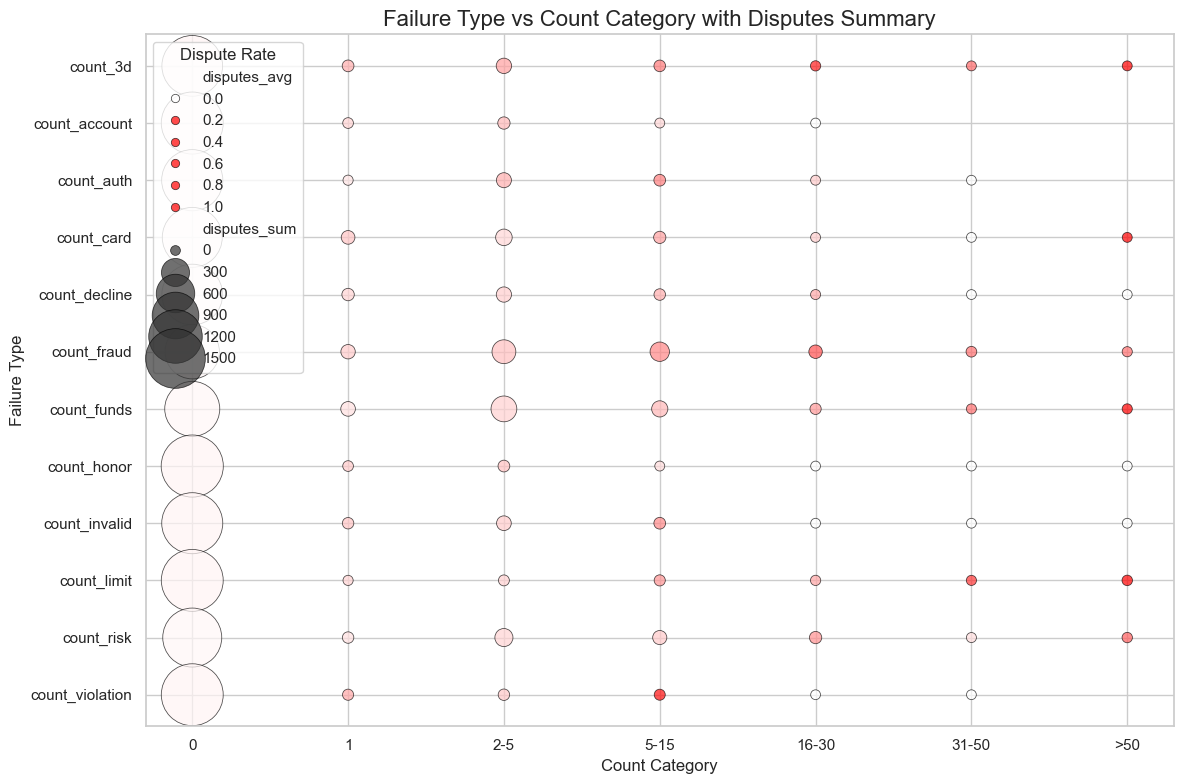

In [ ]:
# Define the custom order for the 'count_category'
category_order = ['0', '1', '2-5', '5-15', '16-30', '31-50', '>50']

# Convert 'count_category' to a categorical type with the custom order
grouped['count_category'] = pd.Categorical(grouped['count_category'], categories=category_order, ordered=True)

# Exclude 'count_empty_string' from the dataset
grouped_filtered = grouped[grouped['failure_type'] != 'count_empty_string']

# Define the color map where the red starts at 0.05 and goes to 0.2
cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_to_white", 
    [(0, 'white'), (1, 'red')], 
    N=100
)

# Normalize the data so that 0.05 corresponds to a light red and 0.2 corresponds to full red
norm = mcolors.Normalize(vmin=0.001, vmax=0.10)

# Create the plot
plt.figure(figsize=(12, 8))

# Bubble plot using Seaborn with custom color palette
sns.scatterplot(data=grouped_filtered, 
                x='count_category', 
                y='failure_type', 
                size='disputes_sum', 
                hue='disputes_avg', 
                sizes=(50, 2000),  # Control bubble sizes
                palette=cmap,      # Apply the custom color palette
                edgecolor='black', 
                alpha=0.7,
                hue_norm=norm)     # Apply the normalization to the hue values

# Title and labels
plt.title("Failure Type vs Count Category with Disputes Summary", fontsize=16)
plt.xlabel('Count Category', fontsize=12)
plt.ylabel('Failure Type', fontsize=12)
plt.legend(title='Dispute Rate', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


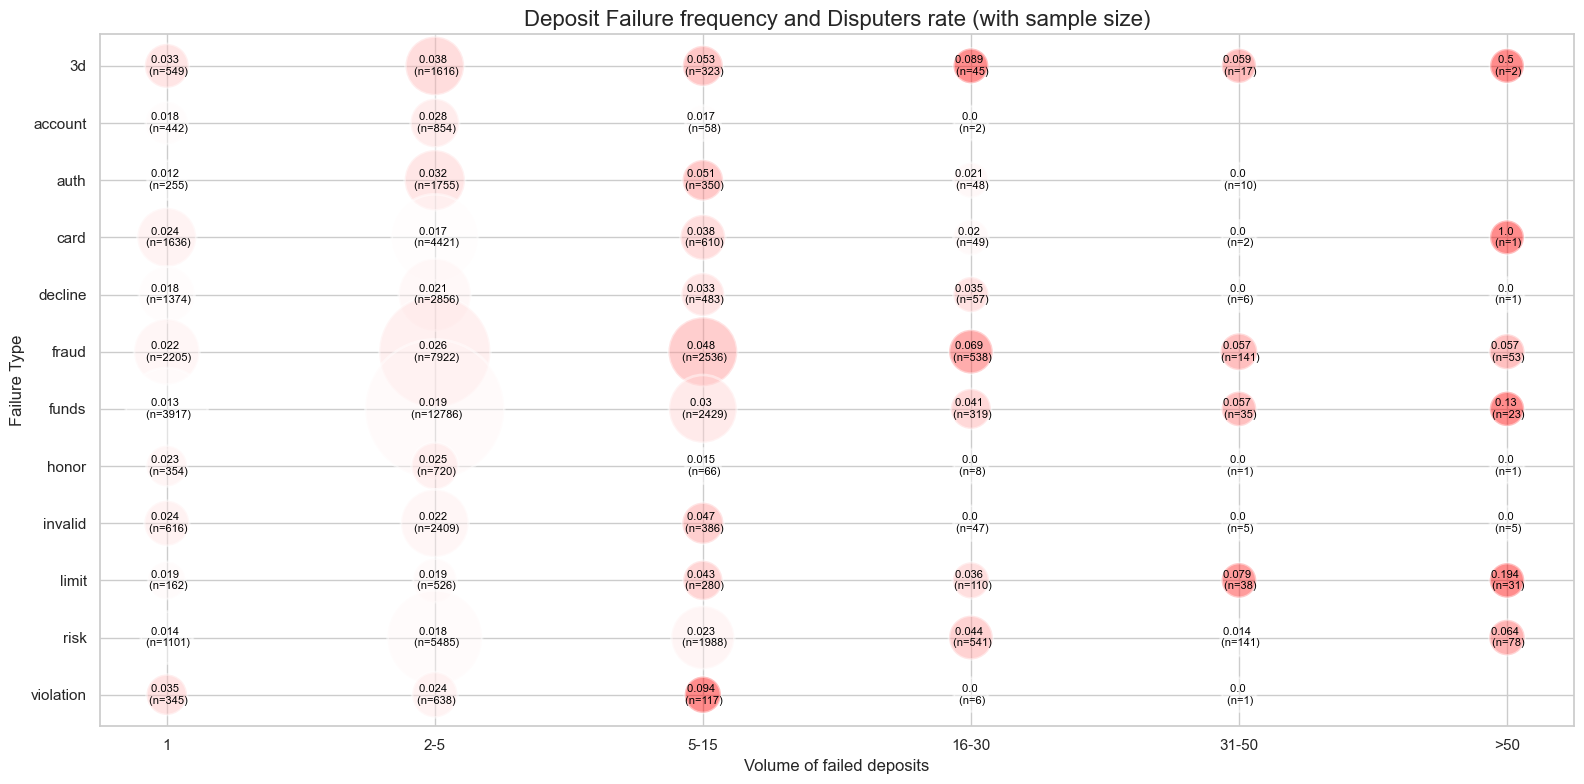

In [ ]:
# Define the custom order for the 'count_category'
category_order = ['0', '1', '2-5', '5-15', '16-30', '31-50', '>50']

# Convert 'count_category' to a categorical type with the custom order
grouped['count_category'] = pd.Categorical(grouped['count_category'], categories=category_order, ordered=True)

# Exclude 'count_empty_string' from the dataset
grouped_filtered = grouped[grouped['failure_type'] != 'empty_string'][grouped['count_category'] != '0']

# Define the color map where the red starts at 0.05 and goes to 0.2
cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_to_white", 
    [(0, 'white'), (1, 'red')], 
    N=100
)

# Normalize the data so that 0.05 corresponds to a light red and 0.2 corresponds to full red
norm = mcolors.Normalize(vmin=0.016, vmax=0.09)

# Create the plot
plt.figure(figsize=(16, 8))

# Bubble plot using Seaborn with custom color palette
scatter = sns.scatterplot(data=grouped_filtered, 
                          x='count_category', 
                          y='failure_type', 
                          size='disputes_count', 
                          hue='disputes_avg', 
                          sizes=(600, 10000),  # Control bubble sizes
                          palette=cmap,      # Apply the custom color palette
                          edgecolor='white', 
                          alpha=0.45,
                          hue_norm=norm, 
                          legend=False)     # Remove the legend

# Add labels for each bubble
for i, row in grouped_filtered.iterrows():
    # Prepare the label text
    dispute_rate = row['disputes_avg']
    count_cases = row['disputes_count']
    label = f'{round(dispute_rate, 3)} \n (n={count_cases})'
    
    # Add the label to the plot
    plt.text(row['count_category'], row['failure_type'], label, 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=8, color='black')

# Title and labels
plt.title("Deposit Failure frequency and Disputers rate (with sample size)", fontsize=16)
plt.xlabel('Volume of failed deposits', fontsize=12)
plt.ylabel('Failure Type', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### Analysis of variety

In [409]:
non_disputers_df = non_disputers_df[non_disputers_df['num_failures']>0][non_disputers_df['fail_type_payment_type_history'].astype(str) != '[None]']
non_disputers_df.sample(2)

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,...,count_violation,count_auth,count_card,count_limit,count_account,count_decline,unique_fail_type_count,num_failures_quantile,unique_fail_percentage,unique_fail_percentage_bin
244321,50035116,50035116,0,com.evl.woc,0,"[None, None]",NaN,2024-08-31 05:43:38.863,3486,[first_b],...,0,0,0,0,0,0,1,0,0.5,"[0.5, 0.6)"
116462,50023824,50023824,0,com.evl.woc,0,"[None, None]",NaN,2024-08-11 11:37:21.581,3106,"[default, first_b]",...,0,0,0,0,0,0,1,0,0.5,"[0.5, 0.6)"


In [410]:
non_disputers_df['unique_fail_type_count'] = non_disputers_df['fail_type_payment_type_history'].apply(lambda x: len(set(x)))
non_disputers_df['unique_fail_percentage'] = non_disputers_df['unique_fail_type_count'] / non_disputers_df['num_failures']
non_disputers_df['unique_fail_percentage'].sample(4)

24328     0.5
46062     0.5
261455    0.5
86418     0.5
Name: unique_fail_percentage, dtype: float64

In [416]:
pd.qcut(non_disputers_df['num_failures'], q=20, labels=False, duplicates='drop')

6         2
9         0
17        0
32        5
33        4
         ..
314824    0
314829    0
314835    0
314839    3
314841    0
Name: num_failures, Length: 80853, dtype: int64

In [417]:
# Generate quantiles for num_deposits
num_deposits_quantiles = pd.qcut(non_disputers_df['num_failures'], q=20, labels=False, duplicates='drop')

# Assign quantile values to a new column in the DataFrame
non_disputers_df['num_failures_quantile'] = num_deposits_quantiles

# Define the bin edges for equal distance intervals (0-0.1, 0.1-0.2, ..., 0.9-1.0)
bin_edges = np.arange(0, 1.1, 0.1)

# Apply pd.cut to create the bins
non_disputers_df['unique_fail_percentage_bin'] = pd.cut(non_disputers_df['unique_fail_percentage'], bins=bin_edges, right=False)
non_disputers_df.sample(2)

,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,...,count_violation,count_auth,count_card,count_limit,count_account,count_decline,unique_fail_type_count,num_failures_quantile,unique_fail_percentage,unique_fail_percentage_bin
191922,10791907,10791907,0,com.acorncasino.slots,0,"[funds, funds, card, card]",NaN,2024-06-29 01:12:50.047,982,"[default, default, default, default, default, ...",...,0,0,2-5,0,0,0,2,2,0.500000,"[0.5, 0.6)"
289371,50279664,50279664,0,com.sparklingtour.tig.ger,0,"[decline, funds, fraud, card, funds, fraud, fr...",NaN,2024-07-26 05:32:36.636,215,"[default, default, default, first_b, default, ...",...,0,0,2-5,0,0,2-5,4,5,0.333333,"[0.3, 0.4)"


In [418]:
non_disputers_df[['unique_fail_type_count', 'fail_type_payment_type_history']].sample(5)

,unique_fail_type_count,fail_type_payment_type_history
156960,1,"[None, None]"
267952,1,"[, , , , , ]"
6731,4,"[risk, invalid, , invalid, invalid, auth, , , ..."
265896,2,"[funds, funds, , ]"
12004,3,"[, account, , , card, account, , card]"


In [ ]:
# Assuming `non_disputers_df` has been aggregated as `aggregated_data`
aggregated_data = non_disputers_df.groupby(['num_failures_quantile', 'unique_fail_percentage_bin']).agg(
    disputes_avg=('unique_fail_percentage', 'mean'),
    disputes_count=('num_failures_quantile', 'sum'),
    unique_fail_type_count=('unique_fail_percentage', 'count')
).reset_index()  # Reset index to turn group keys into columns

# Now we can create the pivot table
pivot_table = aggregated_data.pivot_table(
    index='num_failures_quantile',  # Rows (index)
    columns='unique_fail_percentage_bin',  # Columns
    values=['disputes_avg', 'disputes_count', 'unique_fail_type_count'],  # Values
    aggfunc='first'  # We only have one entry per (num_failures_quantile, unique_fail_percentage_bin) pair, so use 'first'
)

# Display the pivot table
pivot_table

disputes_avg                                   \
unique_fail_percentage_bin   [0.0, 0.1) [0.1, 0.2) [0.2, 0.3) [0.3, 0.4)   
num_failures_quantile                                                      
0                                   NaN        NaN        NaN        NaN   
1                                   NaN        NaN        NaN   0.333333   
2                                   NaN        NaN   0.250000        NaN   
3                                   NaN   0.166667   0.200000   0.333333   
4                                   NaN   0.130415   0.258109   0.375000   
5                              0.084957   0.146090   0.247554   0.338231   
6                              0.064702   0.145604   0.236286   0.335244   
7                              0.064172   0.139266   0.230710   0.325341   

                                                                        \
unique_fail_percentage_bin [0.4, 0.5) [0.5, 0.6) [0.6, 0.7) [0.7, 0.8)   
num_failures_quantile                                                    
0                                 NaN   0.500000        NaN        NaN   
1                                 NaN        NaN   0.666667        NaN   
2                                 NaN   0.500000        NaN    0.75000   
3                            0.400000   0.520159   0.666667        NaN   
4                            0.428571   0.511949   0.625000    0.72619   
5                            0.416227   0.516407        NaN        NaN   
6                            0.427058   0.500000        NaN        NaN   
7                                 NaN        NaN        NaN        NaN   

                                      disputes_count  ...  \
unique_fail_percentage_bin [0.8, 0.9)     [0.0, 0.1)  ...   
num_failures_quantile                                 ...   
0                                 NaN              0  ...   
1                                 NaN              0  ...   
2                                 NaN              0  ...   
3                            0.801111              0  ...   
4                                 NaN              0  ...   
5                                 NaN            910  ...   
6                                 NaN           1536  ...   
7                                 NaN          12390  ...   

                           unique_fail_type_count                        \
unique_fail_percentage_bin             [0.0, 0.1) [0.1, 0.2) [0.2, 0.3)   
num_failures_quantile                                                     
0                                               0          0          0   
1                                               0          0          0   
2                                               0          0       3402   
3                                               0       1040        366   
4                                               0        620       1493   
5                                             182        898       1869   
6                                             256       1530       1312   
7                                            1770       1725        325   

                                                                        \
unique_fail_percentage_bin [0.3, 0.4) [0.4, 0.5) [0.5, 0.6) [0.6, 0.7)   
num_failures_quantile                                                    
0                                   0          0      43648          0   
1                                2710          0          0        653   
2                                   0          0       4127          0   
3                                1985        648       1131        101   
4                                 754        180        269         17   
5                                 464        395         74          0   
6                                 256         21          1          0   
7                                   7          0          0          0   

                                                             


In [ ]:

# Normalize the disputes_avg for coloring purposes
cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_to_white", 
    [(0, 'white'), (1, 'red')], 
    N=100
)

norm = mcolors.Normalize(vmin=0.016, vmax=0.09)  # Adjust based on your data range for dispute rate

# Create the plot
plt.figure(figsize=(16, 8))

# Bubble plot using Seaborn with custom color palette
scatter = sns.scatterplot(data=aggregated_data, 
                          x='num_failures_quantile', 
                          y='unique_fail_percentage_bin', 
                          size='unique_fail_type_count',  # Size by the number of occurrences
                          hue='disputes_avg',  # Use the disputes_avg for color
                          sizes=(600, 10000),  # Control bubble sizes
                          palette=cmap,        # Apply the custom color palette
                          edgecolor='white', 
                          alpha=0.45,
                          hue_norm=norm, 
                          legend=False)     # Remove the legend

# Add labels for each bubble
for i, row in aggregated_data.iterrows():
    # Prepare the label text
    dispute_rate = row['disputes_avg']
    count_cases = row['unique_fail_type_count']
    label = f'{round(dispute_rate, 3)} \n (n={count_cases})'
    
    # Add the label to the plot
    plt.text(row['num_failures_quantile'], row['unique_fail_percentage_bin'], label, 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=8, color='black')

# Title and labels
plt.title("Deposit Failure Frequency and Disputers Rate (with Sample Size)", fontsize=16)
plt.xlabel('Deposit Quantiles', fontsize=12)
plt.ylabel('Unique Failure Percentage Bins', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Combine fraud rules with payment

In [35]:
non_disputers_df['payment_history_time'] = non_disputers_df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')

In [37]:
# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):

    # Is a double scapte
    string = str(string).strip('[]').replace("'", '"').replace("\\2024", "2024").replace("\\", "").replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format = '%Y-%m-%d %H:%M:%S.%f')

# Apply the conversion
non_disputers_df['payment_history_time_clean'] = non_disputers_df['payment_history_time'].apply(convert_to_datetime_list)

In [ ]:

# General function to extract the indexes of payments within a specified number of hours
def extract_within_hours(payment_times, first_pay_time, hours):
    # payment_times_list = [value[1:-1].strip("'") for value in payment_times]
    payment_times_list = payment_times
    payment_times_dt = pd.to_datetime(payment_times_list)
    return [i for i, time in enumerate(payment_times_dt) if time <= first_pay_time + pd.Timedelta(hours=hours)]

# General function to sum payments within specified hours using the extracted indexes
def sum_payments_within_hours(payment_history, indexes):
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    selected_payments = [float(payment_values_list[i].replace('[', '').replace(']', '')) for i in indexes
                            if i < len(payment_values_list)
                            and payment_values_list[i] is not None
                            and payment_values_list[i] != 'None'
                            and payment_values_list[i].replace('[', '').replace(']', '') != ''
                            and payment_values_list[i].replace('[', '').replace(']', '') != '.']

    return sum(selected_payments)

non_disputers_df['first_pay_time'] = pd.to_datetime(non_disputers_df['first_pay_time'])

# Calculate sums for 24, 48, and 72 hours
for hours in [24, int(7*24), int(14*24)]:
    
    col_index_name = f'indexes_within_{hours}_hours'
    col_sum_name = f'sum_payments_within_{hours}_hours'
    
    non_disputers_df[col_index_name] = non_disputers_df.apply(lambda row: extract_within_hours(row['payment_history_time_clean'], row['first_pay_time'], hours), axis=1)
    print(hours)
    non_disputers_df[col_sum_name] = non_disputers_df.apply(lambda row: sum_payments_within_hours(row['payment_history'], row[col_index_name]), axis=1)
    non_disputers_df.drop(columns=[col_index_name], inplace=True)  # Drop the temporary column used for extracting indexes


24
168
336
2.2-2.10


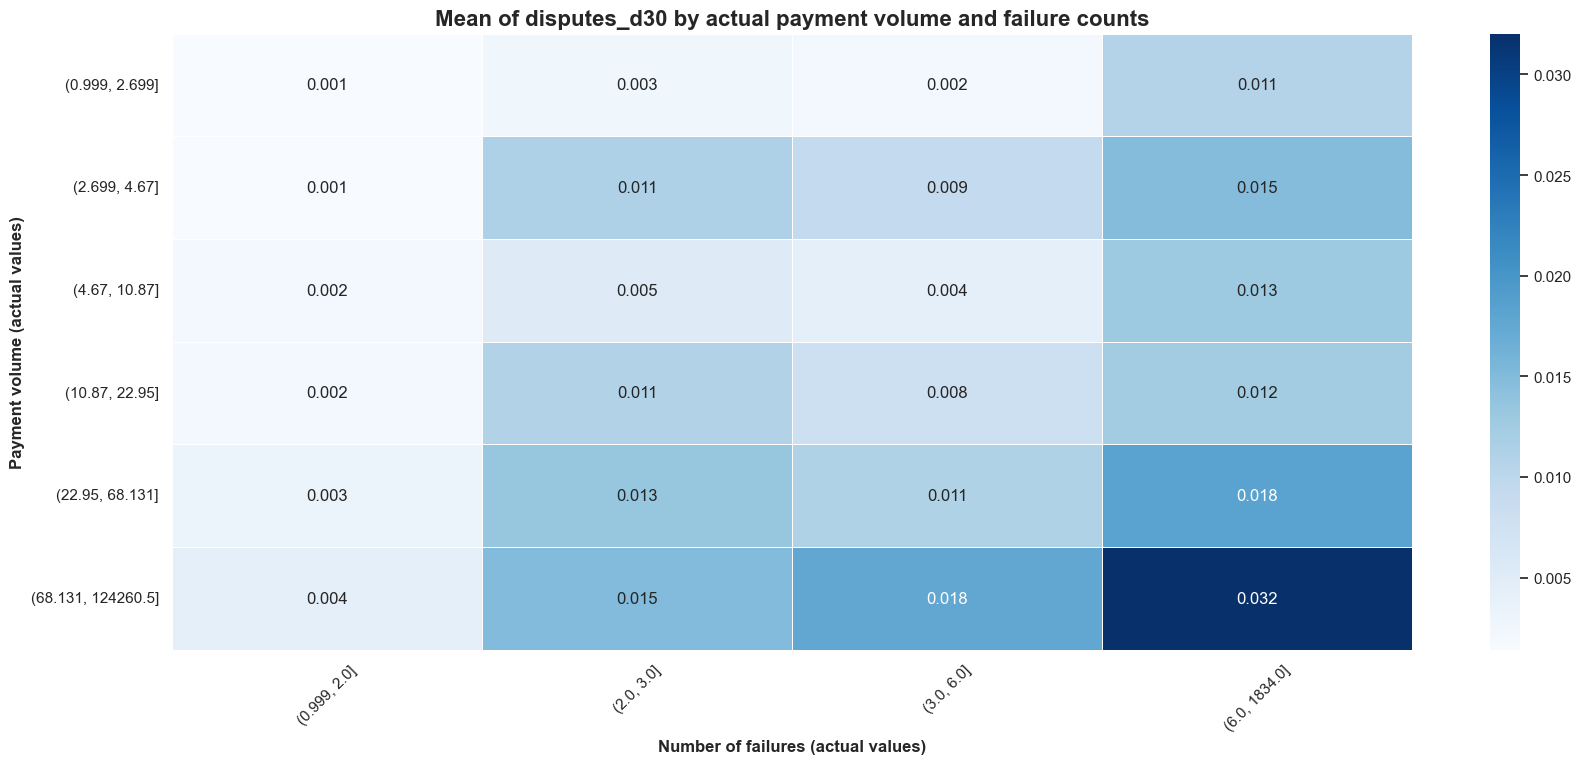

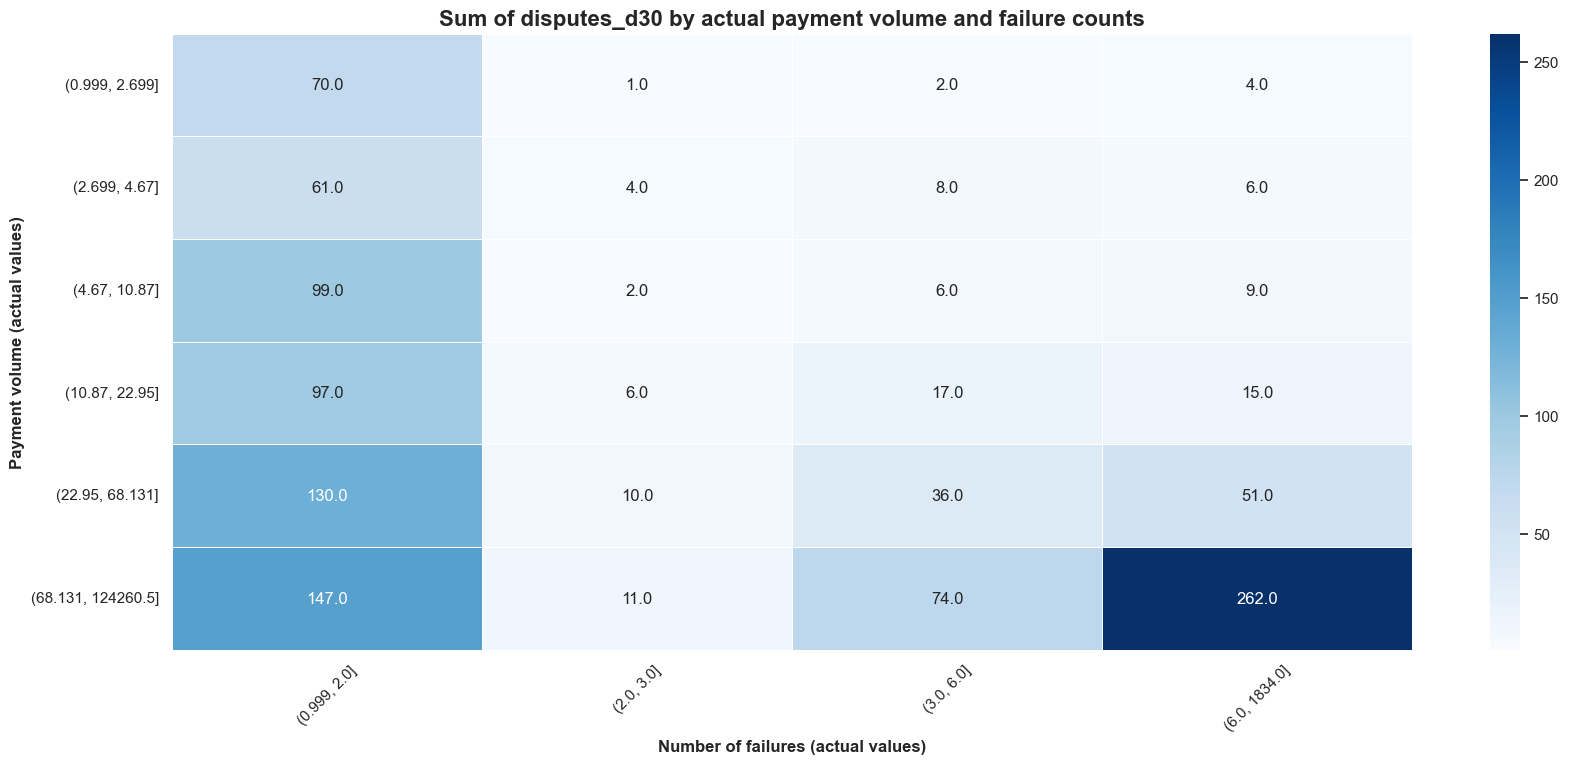

In [ ]:
# Step 1: Filter the dataframe based on 'sum_payments_within_168_hours'
truncated_df = non_disputers_df[non_disputers_df['sum_payments_within_168_hours'] >= 1]

# Step 2: Calculate the actual values at each quantile
truncated_df['payment_d7_quantile_values'] = pd.qcut(truncated_df['sum_payments_within_168_hours'], 6, duplicates='drop')
truncated_df['num_failures_quantile_values'] = pd.qcut(truncated_df['num_failures'], 20, duplicates='drop')

# Step 3: Create the pivot table for mean disputes (as percentage or average)
contingency_table_mean = truncated_df.pivot_table(
    index='payment_d7_quantile_values',
    columns='num_failures_quantile_values',
    values='disputes_d30_binary',
    aggfunc='mean'
)

# Step 4: Create the pivot table for total disputes
contingency_table_sum = truncated_df.pivot_table(
    index='payment_d7_quantile_values',
    columns='num_failures_quantile_values',
    values='disputes_d30_binary',
    aggfunc='sum'
)

# Step 5: Plotting the heatmap for the mean of disputes_d30
plt.figure(figsize = (20, 8))
sns.heatmap(contingency_table_mean, annot=True, fmt=".3f", cmap="Blues", cbar=True, linewidths=.5)
plt.title('Mean of disputes_d30 by actual payment volume and failure counts', fontsize=16, fontweight='bold')
plt.xlabel('Number of failures (actual values)', fontsize=12, fontweight='bold')
plt.ylabel('Payment volume (actual values)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Step 6: Plotting the heatmap for the sum of disputes_d30
plt.figure(figsize = (20, 8))
sns.heatmap(contingency_table_sum, annot=True, fmt=".1f", cmap="Blues", cbar=True, linewidths=.5)
plt.title('Sum of disputes_d30 by actual payment volume and failure counts', fontsize=16, fontweight='bold')
plt.xlabel('Number of failures (actual values)', fontsize=12, fontweight='bold')
plt.ylabel('Payment volume (actual values)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


### Multiple cases

In [86]:
# Extract the unique

# Define the list of failure types, including 'empty_string' for ''
failure_types = ['', '3d', 'funds', 'invalid', 'honor', 'fraud', 'risk', 'violation', 'auth', 'card', 'limit', 'account', 'decline']
failure_types = ['empty_string'] + failure_types[1:]  # Replace '' with 'empty_string'

# Create a column for each failure type
for failure_type in failure_types:
    non_disputers_df[f'count_{failure_type}'] = non_disputers_df['fail_type_payment_type_history'].apply(lambda x: x.count(failure_type))

# Generate the column names
failure_type_names = [f'count_{failure_type}' for failure_type in failure_types]
failure_type_names

['count_empty_string',
 'count_3d',
 'count_funds',
 'count_invalid',
 'count_honor',
 'count_fraud',
 'count_risk',
 'count_violation',
 'count_auth',
 'count_card',
 'count_limit',
 'count_account',
 'count_decline']

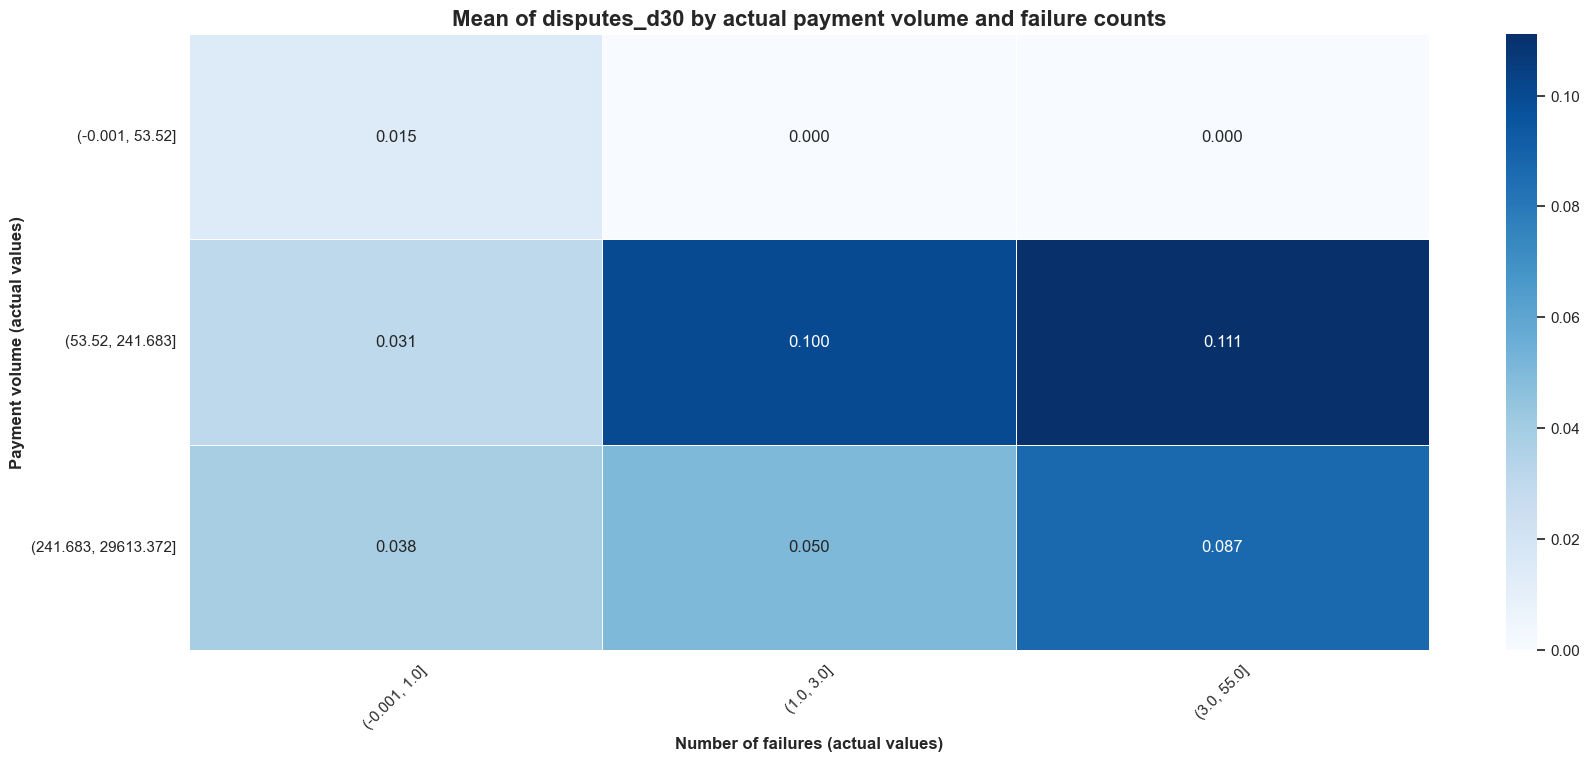

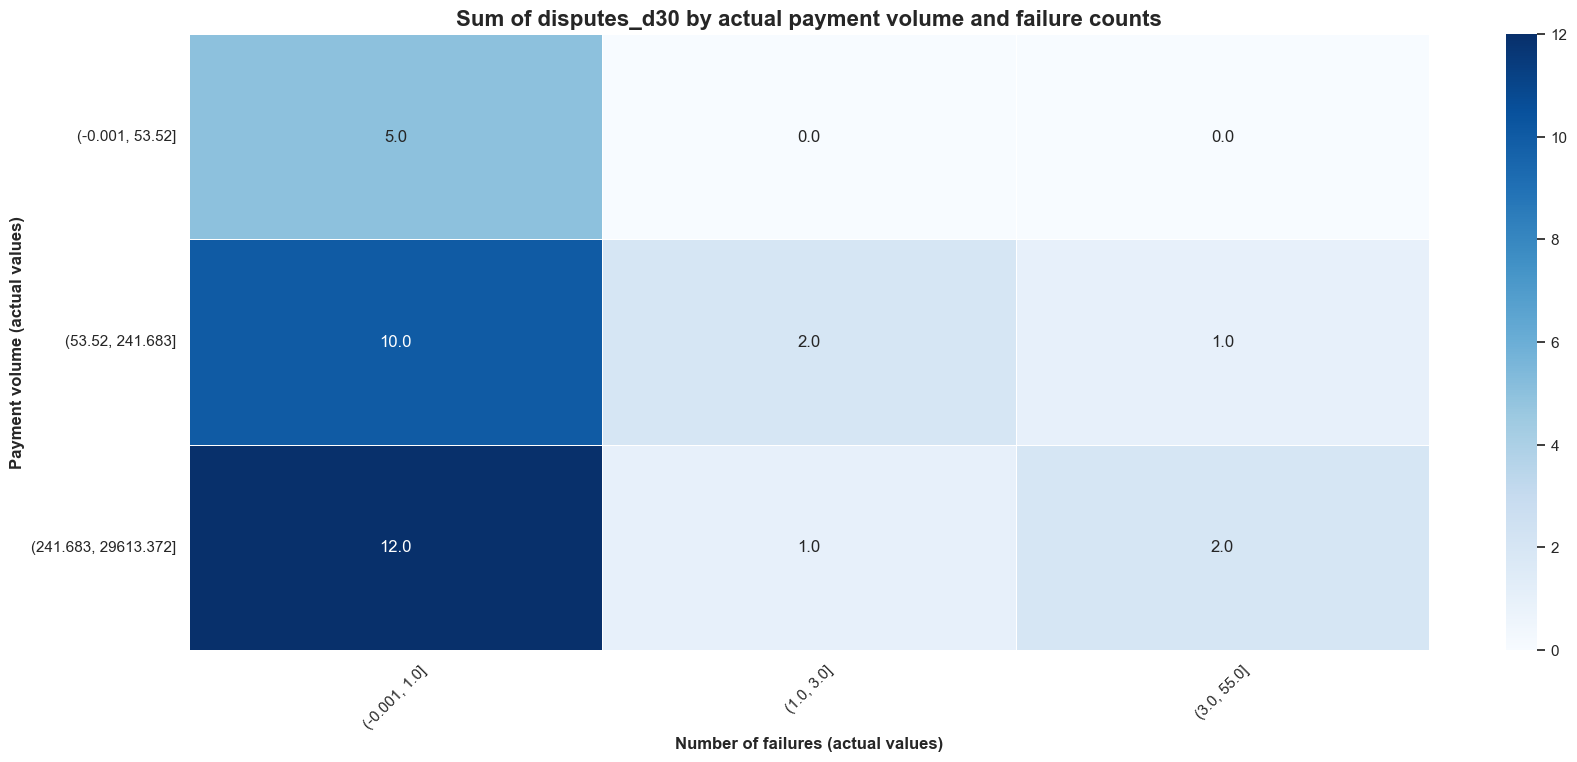

In [124]:
# Step 1: Filter the dataframe based on 'sum_payments_within_168_hours'
truncated_df = non_disputers_df[non_disputers_df['count_violation'] >= 1][non_disputers_df['sum_payments_within_168_hours'] >= 0]

# Step 2: Calculate the actual values at each quantile
truncated_df['payment_d7_quantile_values'] = pd.qcut(truncated_df['sum_payments_within_168_hours'], 3, duplicates='drop')
truncated_df['num_failures_quantile_values'] = pd.qcut(truncated_df['count_3d'], 24, duplicates='drop')

# Step 3: Create the pivot table for mean disputes (as percentage or average)
contingency_table_mean = truncated_df.pivot_table(
    index='payment_d7_quantile_values',
    columns='num_failures_quantile_values',
    values='disputes_d30_binary',
    aggfunc='mean'
)

# Step 4: Create the pivot table for total disputes
contingency_table_sum = truncated_df.pivot_table(
    index='payment_d7_quantile_values',
    columns='num_failures_quantile_values',
    values='disputes_d30_binary',
    aggfunc='sum'
)

# Step 5: Plotting the heatmap for the mean of disputes_d30
plt.figure(figsize=(20, 8))
sns.heatmap(contingency_table_mean, annot=True, fmt=".3f", cmap="Blues", cbar=True, linewidths=.5)
plt.title('Mean of disputes_d30 by actual payment volume and failure counts', fontsize=16, fontweight='bold')
plt.xlabel('Number of failures (actual values)', fontsize=12, fontweight='bold')
plt.ylabel('Payment volume (actual values)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Step 6: Plotting the heatmap for the sum of disputes_d30
plt.figure(figsize=(20, 8))
sns.heatmap(contingency_table_sum, annot=True, fmt=".1f", cmap="Blues", cbar=True, linewidths=.5)
plt.title('Sum of disputes_d30 by actual payment volume and failure counts', fontsize=16, fontweight='bold')
plt.xlabel('Number of failures (actual values)', fontsize=12, fontweight='bold')
plt.ylabel('Payment volume (actual values)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Rules that differ for different matuirity periods

In [ ]:
final_query = f"""
with base as (
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_59 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date" between '{start_date}' AND '{end_date}' and (("is_true" IS NULL) or ("is_true" = true))
    UNION ALL
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_102 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date"  between '{start_date}' AND '{end_date}' and (("is_true" IS NULL) or ("is_true" = true))
)

, users as (
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_59 
    where "#account_id" is not null
    UNION ALL
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_102
    where "#account_id" is not null
)

, payment_aux AS (
select
    a."#account_id"
    , "register_time"
    , "first_pay_time"
    , b.bundle_id
    , array_agg(cast("net_amount" as double)) as payment_history
    , array_agg("#event_time")                as payment_history_time
    , array_agg("pay_enter_name")             as payment_enter_history
    -- , max(if(date_diff('minute', "first_pay_time", "#event_time") <= 28*24*60, "#event_time", null)) over (partition by "#account_id") as max_date
from base a
join users b
    on a."#account_id" = b."#account_id" 
    and a."#event_time" > b."register_time"
where date_diff('minute', "first_pay_time", "#event_time") between 0 and (28*24*60)
    and "first_pay_time"  between date('{start_date}') AND date('{end_date}') 
group by 1,2,3,4
) 

, ios_payments AS (
  select
    a."#account_id"
    , a."first_pay_time"
    , a."bundle_id"
    , payment_history
    , payment_history_time 
    , payment_enter_history 

    , sum((CASE WHEN (date_diff('minute', a."first_pay_time", c."#event_time") <= ((37 * 24) * 60)) THEN 1 ELSE 0 END))                                      disputes_d30  
    -- , sum((CASE WHEN (date_diff('minute', a."first_pay_time", c."#event_time") <= ((37 * 24) * 60)) THEN  CAST(a."net_amount" AS double) ELSE 0.0 END))   disputed_amount_d30
    , min(c."#event_time")                                                                                                                                   first_dispute_time
    
    -- I also want to include the payment type (Secondary), and matuirity 
    , date_diff('hour', a."register_time", a."first_pay_time")                                                                                               hours_first_payment 
    , sum(if(date_diff('minute', a.first_pay_time, c."#event_time") <= 28*24*60, 1, 0))                                                                       already_disputed

  from payment_aux a
    left join (SELECT *, min("#event_time") over (partition by "#account_id") as first_dispute_time FROM ta.v_event_59 WHERE "$part_event" in ('pay_dispute', 'fraud') AND "$part_date" between '{start_date}' AND '{end_date}')  c 
        -- on a.pay_id = c.pay_id
        on a."#account_id" = c."#account_id"

  group by 1, 2, 3, 4, 5, 6, a."register_time"
) 

,  added_failed_payments as (
    select  
        a. "#account_id"
        , array_agg(1)                              AS payment_fail_history
        , array_agg("#event_time")                  AS payment_fail_history_time
        , array_agg("fail_type")                    AS fail_type_payment_type_history

    from ios_payments a
        left join (select DISTINCT "#account_id", "#event_time", "amount", "net_amount", "fail_type" from ta.v_event_59 where "$part_event" = 'order_pay_fail' AND "$part_date" between '{start_date}' AND '{end_date}') as c 
            on a."#account_id" = c."#account_id" 
            and date_diff('minute', a."first_pay_time", c."#event_time") between 0 and 28*24*60
    
    group by 1 
)

select *
from ios_payments as a
    left join added_failed_payments as b on a."#account_id" = b."#account_id"
"""
print(final_query)


with base as (
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_59 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date" between '2024-07-05' AND '2024-10-29' and (("is_true" IS NULL) or ("is_true" = true))
    UNION ALL
    SELECT "bundle_id", "#account_id", pay_id, payment_type, "#event_time", "net_amount", "payment_type", min("#event_time") OVER (PARTITION BY "#account_id") "first_pay_time", "pay_enter_name"
    FROM ta.v_event_102 
    WHERE "$part_event" IN ('order_pay') AND "$Part_date"  between '2024-07-05' AND '2024-10-29' and (("is_true" IS NULL) or ("is_true" = true))
)

, users as (
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_59 
    where "#account_id" is not null
    UNION ALL
    SELECT "bundle_id", "#account_id", "register_time"
    FROM ta.v_user_102
    where "#account_id

In [127]:
d28_df = pull_data(final_query, bs_token, host) 
d28_df.sample(3)

Error parsing JSON: Expecting ':' delimiter: line 1 column 2260 (char 2259)


,#account_id,#account_id(2),already_disputed,bundle_id,disputes_d30,fail_type_payment_type_history,first_dispute_time,first_pay_time,hours_first_payment,payment_enter_history,payment_fail_history,payment_fail_history_time,payment_history,payment_history_time
95696,50088015,50088015,0,com.whiskers.goldslots,0,"[fraud, , , fraud]",NaN,2024-07-11 08:27:46.064,1784,"[default, default, default, default, default, ...","[1, 1, 1, 1]","[2024-07-20 21:07:08.435, 2024-08-05 06:43:02....","[4.48, 9.26, 4.48, 4.48, 9.26, 4.48, 4.48, 9.2...","[2024-07-26 19:05:18.235, 2024-07-11 14:56:00...."
305900,50013934,50013934,0,com.asselin.android.fortunelegends,0,"[fraud, fraud, fraud, fraud]",NaN,2024-07-06 12:48:54.439,-249,[start_pack],"[1, 1, 1, 1]","[2024-07-21 16:03:55.361, 2024-07-21 16:03:54....",[14.2445],[2024-07-21 16:04:47.378]
258943,40657321,40657321,0,com.shrewdscholar.mirthvegas,0,[None],NaN,2024-08-17 22:21:54.817,0,[first_b],[1],[None],[2.65],[2024-08-17 22:21:54.817]


In [154]:
d28_df[~d28_df['first_dispute_time'].isnull()]['first_dispute_time']

256       2024-08-11 22:09:03.879
283       2024-08-02 21:29:51.354
370       2024-10-19 00:40:04.535
403       2024-09-15 01:00:03.214
418       2024-08-27 03:49:03.991
                   ...           
324719    2024-07-08 14:06:38.926
324745    2024-08-06 09:12:06.473
324854    2024-10-14 01:00:06.821
324993    2024-08-06 09:20:02.925
325019    2024-10-08 00:40:04.710
Name: first_dispute_time, Length: 2395, dtype: object

In [146]:
d28_df['payment_fail_history_time'] = d28_df['payment_fail_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')

In [ ]:
def convert_to_datetime_list_v2(string):

    # Is a double scapte
    string = str(string).strip('[]').replace("'", '"').replace("\\2024", "2024").replace("\\", "").replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    date_strs = [None if x == "None" else x for x in date_strs]

    return pd.to_datetime(date_strs, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

d28_df['payment_fail_history_time_clean'] = d28_df['payment_fail_history_time'].apply(convert_to_datetime_list_v2)
d28_df['payment_fail_history_time_clean'] = d28_df['payment_fail_history_time'].apply(convert_to_datetime_list_v2)

In [ ]:
d28_df['max_date'] = d28_df['payment_history_time_clean'].apply(lambda dates: max(dates) if len(dates) > 0 else None)

In [161]:

d28_df['first_pay_time'] = pd.to_datetime(d28_df['first_pay_time'])

# Calculate the difference in days
d28_df['date_diff_failure'] = d28_df.apply(
    lambda row: (row['max_date'] - row['first_pay_time']).days if pd.notnull(row['max_date']) else None,
    axis=1
)

d28_df['date_diff'].max()

28

In [159]:
# Ensure 'first_dispute_time' is in datetime format
d28_df['first_dispute_time'] = pd.to_datetime(d28_df['first_dispute_time'], errors='coerce')

# Calculate the limit date
d28_df['limit_date'] = d28_df['first_pay_time'] + pd.Timedelta(days=1)

# Filter rows where 'first_dispute_time' is null or not after the limit date
filtered_df = d28_df[
    d28_df['first_dispute_time'].isnull() | (d28_df['first_dispute_time'] <= d28_df['limit_date'])
]

In [ ]:
# General function to count cases within specified hours using the extracted indexes
def count_cases_within_hours(event_history, indexes):
    event_history = str(event_history).strip('[]')
    event_values_list = [str(item.strip()) for item in event_history.split(',')]
    selected_payments = [event_values_list[i] for i in indexes
                         if i < len(event_values_list)
                         and event_values_list[i] is not None
                         and event_values_list[i] != 'None'
                         and event_values_list[i].replace('[', '').replace(']', '') != ''
                         and event_values_list[i].replace('[', '').replace(']', '') != '.']
    return len(selected_payments)


In [174]:
d28_df.columns

Index(['#account_id', '#account_id(2)', 'already_disputed', 'bundle_id',
       'disputes_d30', 'fail_type_payment_type_history', 'first_dispute_time',
       'first_pay_time', 'hours_first_payment', 'payment_enter_history',
       'payment_fail_history', 'payment_fail_history_time', 'payment_history',
       'payment_history_time', 'payment_history_time_clean', 'max_date',
       'date_diff', 'payment_fail_history_time_clean', 'limit_date',
       'date_diff_failure'],
      dtype='object')

In [ ]:
d28_df['disputes_d30_binary'] = (d28_df['disputes_d30'] > 0).astype(int)

# This code will take a lot of time (Potencially hald a day to run)
final_results = pd.DataFrame()
for day in [value for value in d28_df['date_diff_failure'].unique() if value != 0][:3]:

    print(day)
    # filter out users who have already dispute 
    non_disputers_by_date = d28_df[(d28_df['first_dispute_time'].isnull()) | (d28_df['first_dispute_time'] >= d28_df['first_pay_time'] + pd.Timedelta(days=day))]
    
    col_index_name = f'indexes_within_{day}days'
    col_sum_name = f'sum_payments_within_{day}hours'

    # Just get the number of users in the first hour
    non_disputers_by_date[col_index_name] = non_disputers_by_date.apply(lambda row: extract_within_hours(row['payment_history_time_clean'], row['first_pay_time'], hours*day), axis=1)
    non_disputers_by_date[col_sum_name] = non_disputers_by_date.apply(lambda row: sum_payments_within_hours(row['payment_history'], row[col_index_name]), axis=1)
    non_disputers_by_date.drop(columns = [col_index_name], inplace = True)  # Drop the temporary column used for extracting indexes

    # Get the count of deposit failures 
    non_disputers_by_date['num_failures'] = non_disputers_by_date.apply(lambda row: extract_within_hours(row['payment_fail_history_time_clean'], row['first_pay_time'], hours*day), axis=1)
    non_disputers_by_date['num_failures'] = non_disputers_by_date.apply(lambda row: count_cases_within_hours(row['payment_fail_history'], row['num_failures']), axis=1)

    # the the analysis 
    iteration_result = non_disputers_by_date.groupby('num_failures')[['disputes_d30_binary']].agg(
        count = ('disputes_d30_binary', 'count'),
        sum = ('disputes_d30_binary', 'sum')).reset_index()
    iteration_result['failure_type'] = 'All'

    # Get the specific cases (Am I sure I want to include this?? Put is a secondary option)
    for failure_type in ['d3', 'fraud', 'violation']:

        non_disputers_df[f'count_{failure_type}'] = non_disputers_df['fail_type_payment_type_history'].apply(lambda x: x.count(failure_type))

        # Aggregate counts and sums for each specific failure type
        iteration_result_ftyp = non_disputers_df.groupby(f'count_{failure_type}')[['disputes_d30_binary']].agg(
            count=('disputes_d30_binary', 'count'),
            sum=('disputes_d30_binary', 'sum')
        ).reset_index()


        iteration_result_ftyp['failure_type'] = failure_type
        iteration_result_ftyp['day'] = day
        iteration_result_ftyp['num_failures'] = iteration_result_ftyp[f'count_{failure_type}']
        del iteration_result_ftyp[f'count_{failure_type}']
        iteration_result_ftyp[['num_failures', 'count', 'sum', 'failure_type', 'day']]
        print(iteration_result_ftyp.columns)

        iteration_result = pd.concat([iteration_result, iteration_result_ftyp], ignore_index=True)

    iteration_result['day'] = day

    final_results = pd.concat([final_results, iteration_result])
    final_results['disputer_rate'] = final_results['sum'] / final_results['count'] 


8
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
21
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
2
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')
Index(['count', 'sum', 'failure_type', 'day', 'num_failures'], dtype='object')


In [277]:
import pandas as pd

d28_df['disputes_d30_binary'] = (d28_df['disputes_d30'] > 0).astype(int)

# This code will take a lot of time (potentially half a day to run)
final_results = pd.DataFrame()
for day in [value for value in d28_df['date_diff_failure'].unique() if value != 0]:
    print(day)

    # Filter out users who have already disputed
    non_disputers_by_date = d28_df[
        (d28_df['first_dispute_time'].isnull()) |
        (d28_df['first_dispute_time'] >= d28_df['first_pay_time'] + pd.Timedelta(days=day))
    ].copy()  # Use `.copy()` to avoid SettingWithCopyWarning

    col_index_name = f'indexes_within_{day}days'
    col_sum_name = f'sum_payments_within_{day}hours'

    # Calculate indexes and sums for the relevant period
    non_disputers_by_date[col_index_name] = non_disputers_by_date.apply(
        lambda row: extract_within_hours(row['payment_history_time_clean'], row['first_pay_time'], hours * day), axis=1)
    non_disputers_by_date[col_sum_name] = non_disputers_by_date.apply(
        lambda row: sum_payments_within_hours(row['payment_history'], row[col_index_name]), axis=1)
    non_disputers_by_date.drop(columns=[col_index_name], inplace=True)  # Drop temporary column used for extracting indexes

    # Count failures within the period
    non_disputers_by_date['num_failures'] = non_disputers_by_date.apply(
        lambda row: extract_within_hours(row['payment_fail_history_time_clean'], row['first_pay_time'], hours * day), axis=1)
    non_disputers_by_date['num_failures'] = non_disputers_by_date.apply(
        lambda row: count_cases_within_hours(row['payment_fail_history'], row['num_failures']), axis=1)

    # Perform aggregation for all failure types
    iteration_result = non_disputers_by_date.groupby('num_failures')[['disputes_d30_binary']].agg(
        count=('disputes_d30_binary', 'count'),
        sum=('disputes_d30_binary', 'sum')).reset_index()
    iteration_result['failure_type'] = 'All'

    # Specific failure types ('d3', 'fraud', 'violation')
    for failure_type in ['d3', 'fraud', 'violation']:
        # Calculate count for the specific failure type
        non_disputers_by_date[f'count_{failure_type}'] = non_disputers_by_date['fail_type_payment_type_history'].apply(
            lambda x: x.count(failure_type))

        # Aggregate counts and sums for the specific failure type
        iteration_result_ftyp = non_disputers_by_date.groupby(f'count_{failure_type}')[['disputes_d30_binary']].agg(
            count=('disputes_d30_binary', 'count'),
            sum=('disputes_d30_binary', 'sum')
        ).reset_index()

        iteration_result_ftyp['failure_type'] = failure_type
        iteration_result_ftyp['day'] = day
        iteration_result_ftyp['num_failures'] = iteration_result_ftyp[f'count_{failure_type}']
        del iteration_result_ftyp[f'count_{failure_type}']
        iteration_result_ftyp = iteration_result_ftyp[['num_failures', 'count', 'sum', 'failure_type', 'day']]

        # Append results
        iteration_result = pd.concat([iteration_result, iteration_result_ftyp], ignore_index=True)

    iteration_result['day'] = day

    # Combine iteration results into the final results
    final_results = pd.concat([final_results, iteration_result], ignore_index=True)

# Calculate disputer rate
final_results['disputer_rate'] = final_results['sum'] / final_results['count']


8
21
2
22
27
4
3
25
23
9
19
24
7
13
12
15
1
16
14
5
26
17
6
11
20
18
10
28


In [278]:
final_results

,num_failures,count,sum,failure_type,day,disputer_rate
0,0,258882,363,All,8,0.001402
1,1,2988,10,All,8,0.003347
2,2,19096,108,All,8,0.005656
3,3,2349,26,All,8,0.011069
4,4,9177,66,All,8,0.007192
...,...,...,...,...,...,...
15725,66,1,0,violation,28,0.000000
15726,71,1,0,violation,28,0.000000
15727,72,1,0,violation,28,0.000000
15728,76,1,0,violation,28,0.000000


In [239]:
final_results = final_results[final_results['num_failures'] > 0]

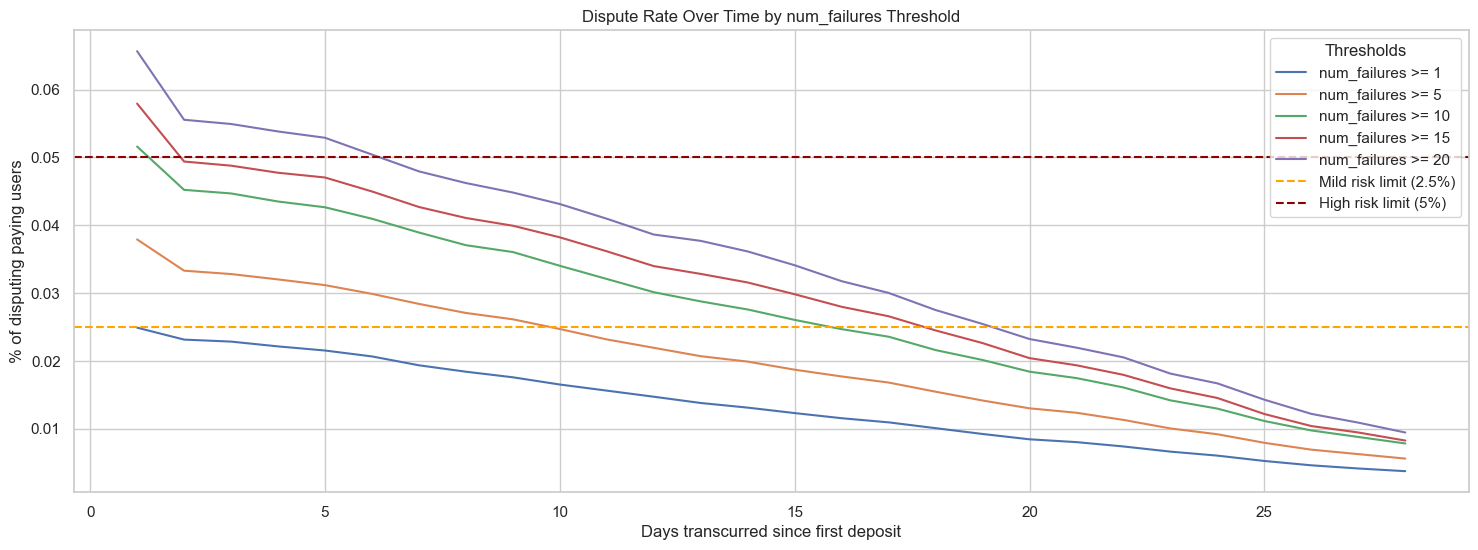

In [247]:
# I want to generate a time series plot, that each line is the dispute rate where num_failures is greater than X. 
# final_results.to_csv('little_shit.csv')
thresholds = [1, 5, 10, 15, 20]

# Recalculate dispute rates based on the sum of counts and sums for each day and threshold
dispute_rate_by_threshold = {}
for threshold in thresholds:
    filtered_data = final_results[(final_results['failure_type'] == 'All') & (final_results['num_failures'] > threshold)]
    aggregated_data = filtered_data.groupby('day').agg({'count': 'sum', 'sum': 'sum'})
    aggregated_data['dispute_rate'] = aggregated_data['sum']*1.535 / aggregated_data['count']
    dispute_rate_by_threshold[threshold] = aggregated_data['dispute_rate']

# Plot the results
plt.figure(figsize = (18, 6))
for threshold, rates in dispute_rate_by_threshold.items():
    plt.plot(rates.index, rates.values, label = f"num_failures >= {threshold}")

plt.axhline(y=0.025, color='orange', linestyle='--', label='Mild risk limit (2.5%)')
plt.axhline(y=0.05, color='darkred', linestyle='--', label='High risk limit (5%)')

# Customize the plot
plt.title("Dispute Rate Over Time by num_failures Threshold")
plt.xlabel("Days transcurred since first deposit")
plt.ylabel("% of disputing paying users")
plt.legend(title="Thresholds")
plt.grid(True)
plt.show()

In [ ]:
# ['d3', 'fraud', 'violation']:

In [268]:
final_results[final_results['failure_type'] == 'violation'].sample(6)
# this 

,num_failures,count,sum,failure_type,day
482,8,21,0,violation,2
489,17,1,0,violation,8
484,10,12,1,violation,2
493,24,1,0,violation,2
490,17,1,0,violation,2
477,3,114,4,violation,2


In [286]:
final_results[(final_results['failure_type'] == 'd3')]

,num_failures,count,sum,failure_type,day,disputer_rate
387,0,324520,1124,d3,8,0.003464
954,0,323846,450,d3,21,0.001390
1520,0,324873,1477,d3,2,0.004546
2088,0,323805,409,d3,22,0.001263
2649,0,323621,225,d3,27,0.000695
3215,0,324778,1382,d3,4,0.004255
3786,0,324835,1439,d3,3,0.004430
4352,0,323687,291,d3,25,0.000899
4913,0,323761,365,d3,23,0.001127
5477,0,324452,1056,d3,9,0.003255


In [271]:
final_results[(final_results['failure_type'] == 'd3') & (final_results['num_failures'] == 8)]

,num_failures,count,sum,failure_type,day


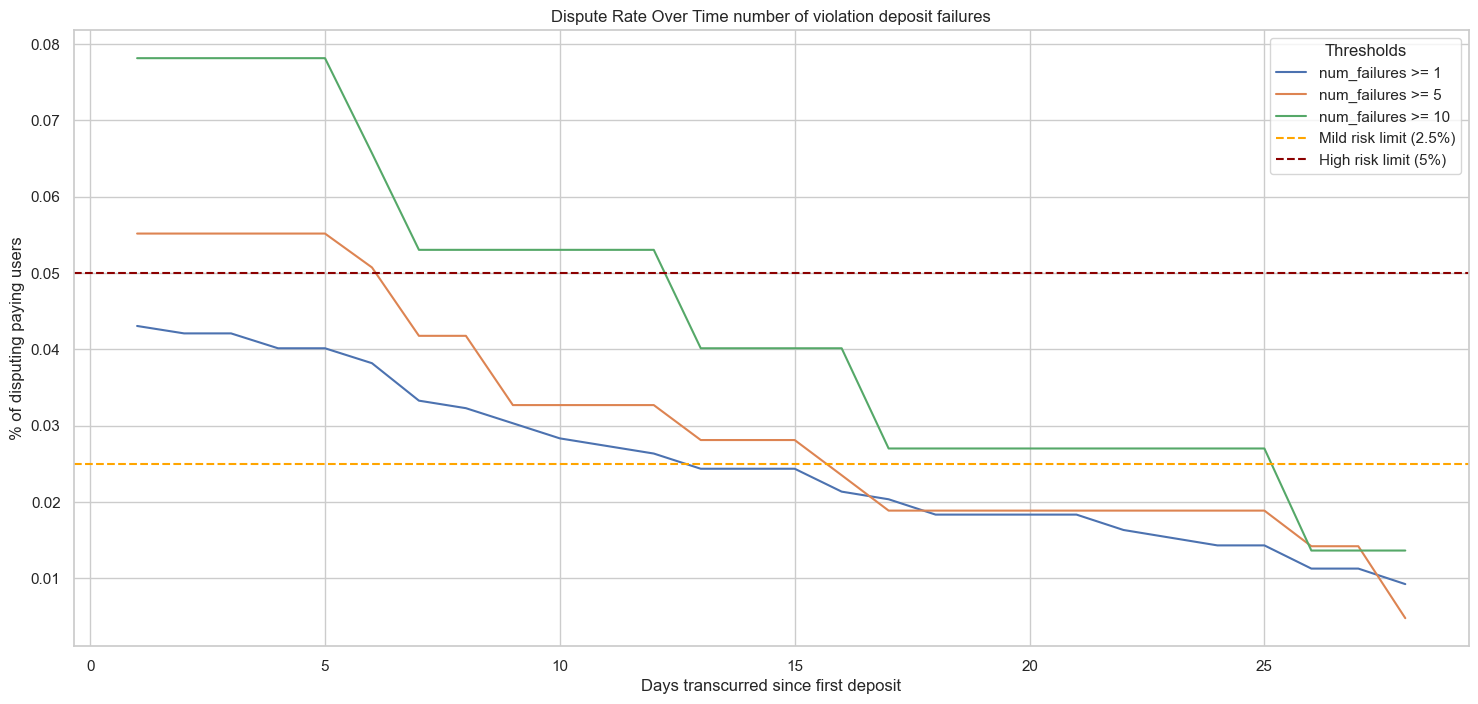

In [289]:
# I want to generate a time series plot, that each line is the dispute rate where num_failures is greater than X. 
# final_results.to_csv('little_shit.csv')
thresholds = [1, 5, 10]

# Recalculate dispute rates based on the sum of counts and sums for each day and threshold
dispute_rate_by_threshold = {}
for threshold in thresholds:
    filtered_data = final_results[(final_results['failure_type'] == 'violation') & (final_results['num_failures'] > threshold)]
    aggregated_data = filtered_data.groupby('day').agg({'count': 'sum', 'sum': 'sum'})
    aggregated_data['dispute_rate'] = aggregated_data['sum']*1.485 / aggregated_data['count']
    dispute_rate_by_threshold[threshold] = aggregated_data['dispute_rate']

# Plot the results
plt.figure(figsize = (18, 8))
for threshold, rates in dispute_rate_by_threshold.items():
    plt.plot(rates.index, rates.values, label = f"num_failures >= {threshold}")

plt.axhline(y=0.025, color='orange', linestyle='--', label='Mild risk limit (2.5%)')
plt.axhline(y=0.05, color='darkred', linestyle='--', label='High risk limit (5%)')

# Customize the plot
plt.title("Dispute Rate Over Time number of violation deposit failures")
plt.xlabel("Days transcurred since first deposit")
plt.ylabel("% of disputing paying users")
plt.legend(title="Thresholds")
plt.grid(True)
plt.show()

### Validation

I can validate these numbers by checking one case where day 

In [295]:
wan = 10000
quantity = 84*wan
rate = 5*wan/quantity
delay_months = 8 + 6
delay_cost = 1 + (rate) * delay_months/12
initial_quantity = quantity * delay_cost
return_rate = 5*wan / initial_quantity
return_rate

0.05565862708719852

In [296]:
500/4

125.0

0          0
1          8
2         21
3          0
4          0
          ..
325085    11
325086     0
325087     8
325088    25
325089     0
Name: date_diff, Length: 325090, dtype: int64

In [142]:
d28_df['date_diff'].max()

28

In [131]:

### Validate the data is within 28 days of frame. 

# find the maximum date for each row in a column which rows are lists of dates 
d28_df['max_paytime'] = d28_df['payment_history_time_clean'].apply(lambda dates: max(dates) if dates else None)
d28_df['max_paytime'].sample(20)


ValueError: The truth value of a DatetimeIndex is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:

for day in days_since_payment:

    x = 


In [ ]:
non_disputers_d28_df = d28_df[d28_df['already_disputed'] == 0]

In [278]:
pivoted_df

,disputes_d30_binary,Failure Type,Count,disputes_d30_count,disputes_d30_sum
0,0,count_empty_string,0,314384,1182
1,0,count_empty_string,0,314384,1182
2,0,count_empty_string,0,314384,1182
3,0,count_empty_string,0,314384,1182
4,0,count_empty_string,0,314384,1182
...,...,...,...,...,...
4086987,0,count_decline,0,314384,1182
4086988,0,count_decline,0,314384,1182
4086989,0,count_decline,0,314384,1182
4086990,0,count_decline,0,314384,1182


In [272]:
pivoted_df.groupby('Failure Type')['Count'].size()

Failure Type
count_3d              314858
count_account         314858
count_auth            314858
count_card            314858
count_decline         314858
count_empty_string    314858
count_fraud           314858
count_funds           314858
count_honor           314858
count_invalid         314858
count_limit           314858
count_risk            314858
count_violation       314858
Name: Count, dtype: int64

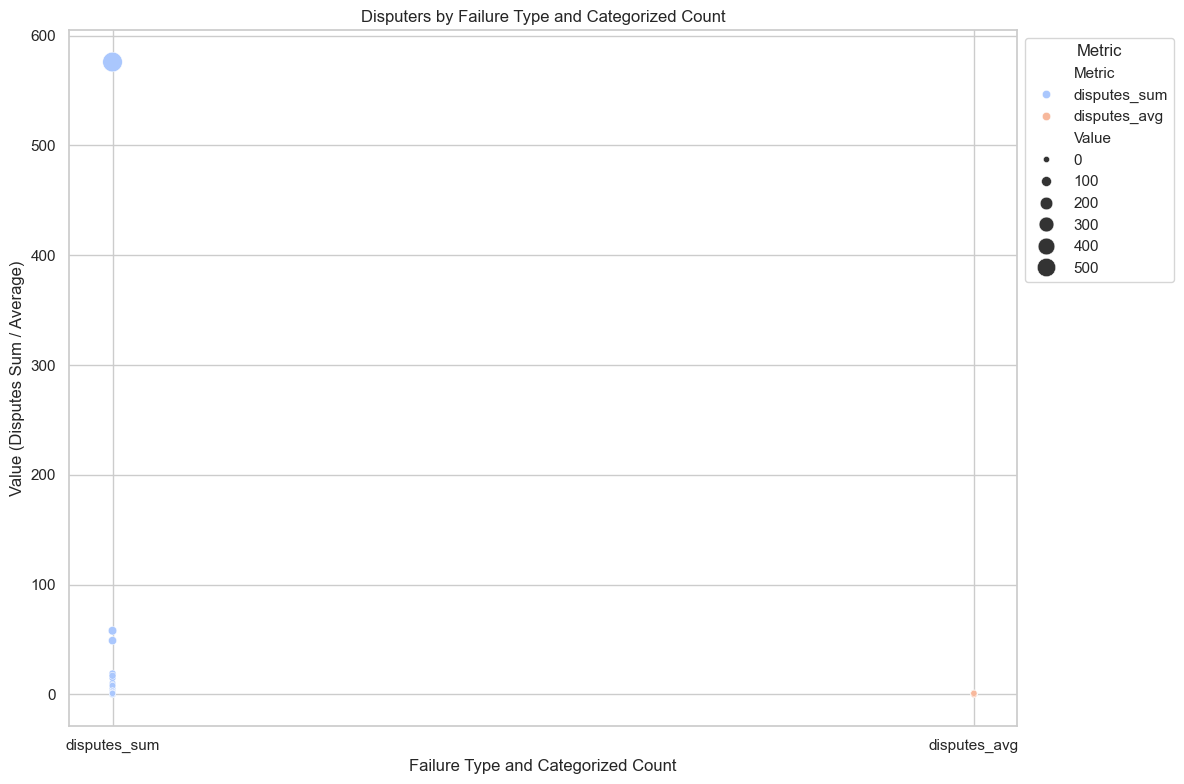

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you already have `non_disputers_df` with the categorized columns (`count_3d`, `count_funds`, etc.)

# Step 1: Group the data by failure type and categorized counts (e.g., '1', '2-5', etc.)
grouped = non_disputers_df.groupby(failure_type_names).agg(
    disputes_sum=('disputes_d30_binary', 'sum'),
    disputes_avg=('disputes_d30_binary', 'mean')
).reset_index()

# Step 2: Prepare the data for plotting
# Melt the DataFrame into long format to have one row per failure type/categorized count pair
grouped_melted = pd.melt(grouped, id_vars=failure_type_names, 
                         value_vars=['disputes_sum', 'disputes_avg'], 
                         var_name='Metric', value_name='Value')

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bubble plot: x is failure types, y is metrics (sum/avg), size is the disputes_sum, and color is the disputes_avg
sns.scatterplot(data=grouped_melted, x="Metric", y="Value", 
                size='Value', hue='Metric', sizes=(20, 200), palette='coolwarm', legend=True)

# Add labels and titles
plt.title("Disputers by Failure Type and Categorized Count")
plt.xlabel("Failure Type and Categorized Count")
plt.ylabel("Value (Disputes Sum / Average)")
plt.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a scatter plot
scatter = plt.scatter(
    x=grouped_df.index,  # X-axis: failure type index
    y=grouped_df['failure_count'],  # Y-axis: count of failure types
    s=grouped_df['disputes_sum'] * 10,  # Size of bubbles: disputes sum (scaled)
    c=grouped_df['dispute_rate'],  # Color: dispute rate
    cmap='viridis',  # Colormap for dispute rate
    alpha=0.6,  # Transparency
)

# Add labels and title
plt.xlabel('Failure Type')
plt.ylabel('Failure Type Count')
plt.title('Failure Types vs. Dispute Metrics')

# Add color bar for dispute rate
plt.colorbar(scatter, label='Dispute Rate')

# Customize x-ticks with failure types
plt.xticks(ticks=grouped_df.index, labels=failure_type_names, rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()
